# US GM & JW New Customer Model

In this Notebook is the process to fit a model to predict the drop probability for each new customer.

A new customer is defined as all the MDMCustomerID with 3 closed loans.

To train the model, the data contains MDMCustomers with all the loans in a **within** range status, and with ORP_changes = 0.

# Libraries

In [1]:
import pandas as pd
from uszipcode import SearchEngine
import mpu
from dfply import *
import numpy as np
from plotnine import *
import gc
from math import radians
from mizani.formatters import percent_format
from mizani.formatters import comma_format
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
import pickle
import math
from sklearn.metrics import (mean_squared_error,mean_absolute_error,
                             r2_score,explained_variance_score, roc_auc_score,
                            classification_report, confusion_matrix,
                            roc_curve, accuracy_score,auc,log_loss)
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import random

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 

## Versions

In [2]:
pd.__version__

'1.0.3'

In [3]:
import sklearn
sklearn.__version__

'0.23.1'

In [4]:
lgb.__version__

'2.3.1'

In [5]:
import scipy
scipy.__version__

'1.4.1'

In [6]:
joblib.__version__

'0.14.1'

In [7]:
import imblearn
imblearn.__version__

'0.5.0'

In [8]:
from platform import python_version
print(python_version())

3.7.6


In [9]:
 import sys
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)

//anaconda3/bin/python
3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


# Read Data

In [10]:
datas = pd.read_csv('/Users/darias/Documents/New_Customer_Model_V5/US/Data_In/US_GMJW_NewCustomer_Data.csv',sep=",")

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,41,91,93,94,95,98,99,102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
datas['LoanCount'] = datas['rank']

In [12]:
len(datas)

932772

# Data Engineering

## Fix zip code

If Zip code has more than 5 characters or includes some non numeric character, will be 'Other_ZipCode'

In [13]:
datas=(
datas >>
    mutate(CustomerZip = if_else(X.CustomerZip.str.len() > 5, 'Other_ZipCode', X.CustomerZip)) >>
    mutate(CustomerZip = if_else(X.CustomerZip.str.isnumeric() == True, X.CustomerZip, 'Other_ZipCode'))
)

In [14]:
gc.collect()

46

In [15]:
datas['storeZip']=datas['storeZip'].astype('str').str.replace('\\.0', '')

## Zip code area

First 2 digits for each zip code

In [16]:
datas = (
datas >>
    mutate(CustomerZip_area = if_else(X.CustomerZip == 'Other_ZipCode',
                                      'Other_ZipCode',
                                      X.CustomerZip.str[0:2]))
)

## Store & Customer Zip Distance

Get US Zip data

In [17]:
search = SearchEngine(simple_zipcode=True)

In [18]:
# Get unique Customer Zip codes
Unique_Customer_Zip = datas['CustomerZip'].unique()

# Calculate de lat & lon for each zip code
lat_tmp_Cust        = pd.Series(Unique_Customer_Zip).map(lambda x: search.by_zipcode(x).lat)
lon_tmp_Cust        = pd.Series(Unique_Customer_Zip).map(lambda x: search.by_zipcode(x).lng)

# Put lat & lon into a data frame
Customer_lat_lon = pd.DataFrame([Unique_Customer_Zip,lat_tmp_Cust,lon_tmp_Cust]).T
Customer_lat_lon.columns = ['CustomerZip', 'Customer_lat', 'Customer_lon']

In [19]:
# The same for stores zip codes

Unique_Store_Zip = pd.Series(datas['storeZip'].unique().astype('str')).str.replace('\\.0', '')
lat_tmp_Store    = pd.Series(Unique_Store_Zip).map(lambda x: search.by_zipcode(x).lat)
lon_tmp_Store    = pd.Series(Unique_Store_Zip).map(lambda x: search.by_zipcode(x).lng)

Store_lat_lon = pd.DataFrame([Unique_Store_Zip,lat_tmp_Store,lon_tmp_Store]).T
Store_lat_lon.columns = ['storeZip', 'Store_lat', 'Store_lon']

# Fix for a Utah Zip code
Store_lat_lon[Store_lat_lon['storeZip'] == '84129']['Store_lat'] = 40.6572776
Store_lat_lon[Store_lat_lon['storeZip'] == '84129']['Store_lon'] = -111.98425

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [20]:
# Add the customer lat and lon in the data
datas = datas.merge(Customer_lat_lon, on = 'CustomerZip', how = 'left')

In [21]:
gc.collect()

40

In [22]:
# Add the store lat and lon in the data
datas = datas.merge(Store_lat_lon, on = 'storeZip', how = 'left')

In [23]:
gc.collect()

20

Function to calculate the distance between two points in the planet

In [24]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
 
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

Put latitudes and longitudes in float

In [25]:
datas['Customer_lon'] = datas['Customer_lon'].astype('float')
datas['Customer_lat'] = datas['Customer_lat'].astype('float')
datas['Store_lon']    = datas['Store_lon'].astype('float')
datas['Store_lat']    = datas['Store_lat'].astype('float')

Calculate the distance between Customer and Store zip

In [26]:
datas['distance_Cust_Store'] = haversine_vectorize(datas['Customer_lon'],
                                                   datas['Customer_lat'],
                                                   datas['Store_lon'],
                                                   datas['Store_lat'])

In [27]:
gc.collect()

98

## Days since first loan

Add first loan date for each MDMcustomer

In [28]:
datas['originDate']=pd.to_datetime(datas['originDate'])

In [29]:
first_loan_date=pd.DataFrame(datas.groupby('MDMcustomerID')['originDate'].min()).reset_index()

In [30]:
first_loan_date.columns = ['MDMcustomerID', 'min_orig_date']

In [31]:
datas = datas.merge(first_loan_date,
                    on  = 'MDMcustomerID',
                    how = 'left')

In [32]:
datas['antiquity_days']=datas['originDate'] - datas['min_orig_date']
datas['antiquity_days']=datas['antiquity_days'].dt.days

## CategoryDesc Groups

Put Category Descriptions in different groups, using the drop percentage for each category desctiption distribution.

In [33]:
CategoryDesc_pctDrop=(
datas >>
    group_by(X.CategoryDesc) >>
    summarise(drops   = if_else(X.lastAction == 'Drop Loan', 1, 0).sum(),
              redeems = if_else(X.lastAction == 'Loan Redemption', 1, 0).sum(),
              cases   = n(X.lastAction)) >>
    ungroup >>
    mutate(CategoryDesc = if_else(X.cases < 1000,
                                  'Other_CategoryDesc',
                                  X.CategoryDesc)) >>
    group_by(X.CategoryDesc) >>
    summarise(drops   = X.drops.sum(),
              redeems = X.redeems.sum(),
              cases   = X.cases.sum()) >>
    ungroup >>
    mutate(pct_drop = X.drops/X.cases) >>
    arrange(X.pct_drop) >>
    mask(X.CategoryDesc != 'Other_CategoryDesc')
)

In [34]:
q2=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.02)
q5=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.05)
q10=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.1)
q20=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.2)
q30=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.3)
q40=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.4)
q50=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.5)
q60=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.6)
q70=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.7)
q80=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.8)
q90=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.9)
q95=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.95)
q98=np.quantile(CategoryDesc_pctDrop['pct_drop'],0.98)

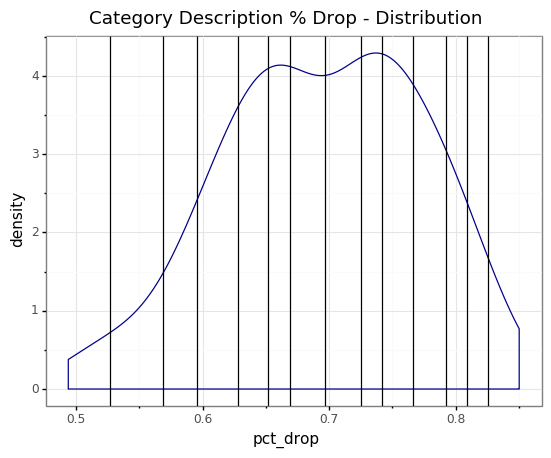

<ggplot: (349092345)>

In [35]:
(
CategoryDesc_pctDrop >>
    ggplot() +
    geom_density(aes('pct_drop'), colour = 'darkblue') +
    theme_bw() +
    geom_vline(xintercept = q2) +
    geom_vline(xintercept = q5) +
    geom_vline(xintercept = q10) +
    geom_vline(xintercept = q20) +
    geom_vline(xintercept = q30) +
    geom_vline(xintercept = q40) +
    geom_vline(xintercept = q50) +
    geom_vline(xintercept = q60) +
    geom_vline(xintercept = q70) +
    geom_vline(xintercept = q80) +
    geom_vline(xintercept = q90) +
    geom_vline(xintercept = q95) +
    geom_vline(xintercept = q98) +
    ggtitle('Category Description % Drop - Distribution')
)

In [36]:
qs = [0,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,1]
CategoryDesc_cluster=pd.qcut(CategoryDesc_pctDrop[CategoryDesc_pctDrop['CategoryDesc']!='Other_CategoryDesc']['pct_drop'],
                             q=qs,
                             labels=['CatDesc_q2','CatDesc_q5','CatDesc_q10',
                                     'CatDesc_q20','CatDesc_q30','CatDesc_q40',
                                     'CatDesc_q50','CatDesc_q60','CatDesc_q70',
                                     'CatDesc_q80','CatDesc_q90','CatDesc_q95',
                                     'CatDesc_q98', 'CatDesc_q100'])

CategoryDesc_pctDrop['CategoryDesc_cluster']=CategoryDesc_cluster

In [37]:
joblib.dump(CategoryDesc_pctDrop,"/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_CategoryDesc_Dictionary.pkl")

['/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_CategoryDesc_Dictionary.pkl']

## Grouped data

Add the Category Description clusters to the data, also the number of items and the item condition cases

In [38]:
datas = datas.merge(CategoryDesc_pctDrop[['CategoryDesc','CategoryDesc_cluster']],
                    on  = 'CategoryDesc',
                    how = 'left')

In [39]:
CatDescClus=datas['CategoryDesc_cluster'].copy()
CatDescClus=CatDescClus.cat.add_categories('Other_CategoryDesc')
CatDescClus=CatDescClus.fillna('Other_CategoryDesc')
datas['CategoryDesc_cluster']=CatDescClus

In [40]:
#datas_train=(
#datas >>
#    group_by(X.MDMcustomerID, X.primaryLoan, X.store, X.CustomerZip_area,
#             X.distance_Cust_Store, X.LoanCount, X.loanExtensions, X.PUR,
#             X.lastAction) >>
#    summarise(item_cond_A = if_else(X.item_cond == 'A', 1, 0).sum(),
#              item_cond_B = if_else(X.item_cond == 'B', 1, 0).sum(),
#              item_cond_C = if_else(X.item_cond == 'C', 1, 0).sum(),
#              
#              num_items   = n(X.primaryLoan),
#              
#              CatDesc_q2  = if_else(X.CategoryDesc_cluster == 'CatDesc_q2',  1, 0).sum(),
#              CatDesc_q5  = if_else(X.CategoryDesc_cluster == 'CatDesc_q5',  1, 0).sum(),
#              CatDesc_q10 = if_else(X.CategoryDesc_cluster == 'CatDesc_q10', 1, 0).sum(),
#              CatDesc_q20 = if_else(X.CategoryDesc_cluster == 'CatDesc_q20', 1, 0).sum(),
#              CatDesc_q30 = if_else(X.CategoryDesc_cluster == 'CatDesc_q30', 1, 0).sum(),
#              CatDesc_q40 = if_else(X.CategoryDesc_cluster == 'CatDesc_q40', 1, 0).sum(),
#              CatDesc_q50 = if_else(X.CategoryDesc_cluster == 'CatDesc_q50', 1, 0).sum(),
#              CatDesc_q60 = if_else(X.CategoryDesc_cluster == 'CatDesc_q60', 1, 0).sum(),
#              CatDesc_q70 = if_else(X.CategoryDesc_cluster == 'CatDesc_q70', 1, 0).sum(),
#              CatDesc_q80 = if_else(X.CategoryDesc_cluster == 'CatDesc_q80', 1, 0).sum(),
#              CatDesc_q90 = if_else(X.CategoryDesc_cluster == 'CatDesc_q90', 1, 0).sum(),
#              CatDesc_q95 = if_else(X.CategoryDesc_cluster == 'CatDesc_q95', 1, 0).sum(),
#              CatDesc_q98 = if_else(X.CategoryDesc_cluster == 'CatDesc_q98', 1, 0).sum())
#)

In [41]:
group_features = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days', 'store',
                  'CustomerZip_area', 'CustomerState', 'distance_Cust_Store', 'LoanCount',
                  'loanExtensions', 'PUR', 'lastAction','Primary']

In [42]:
group_features2 = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days', 'store',
                  'CustomerZip_area', 'CustomerState', 'distance_Cust_Store', 'LoanCount',
                  'loanExtensions', 'PUR', 'lastAction']

In [43]:
# Number of items for each item condition
item_cond_data=datas.groupby(group_features).item_cond.value_counts().unstack().fillna(0).reset_index()

# Get data for GM & JW for separate
item_cond_data_GM = item_cond_data[item_cond_data.Primary == 'General Merchandise']
item_cond_data_JW = item_cond_data[item_cond_data.Primary == 'Jewelry']

# Change names for item condition
item_cond_data_GM.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'A_GM', 'B_GM', 'C_GM', 'N_GM']


item_cond_data_JW.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'A_JW', 'B_JW', 'C_JW', 'N_JW']

# Drop Primary Column
item_cond_data_GM = item_cond_data_GM.drop(columns = ['Primary'])
item_cond_data_JW = item_cond_data_JW.drop(columns = ['Primary'])

# Create a table with all possible unique cases
item_cond_data = item_cond_data[group_features2].drop_duplicates().copy()

# Add the items for each item condition, for GM & JW
item_cond_data = item_cond_data.merge(item_cond_data_GM,on=group_features2,how='left')
item_cond_data = item_cond_data.merge(item_cond_data_JW,on=group_features2,how='left')

# Fill NA with 0
item_cond_data[['A_GM', 'B_GM', 'C_GM', 'N_GM',
                'A_JW', 'B_JW', 'C_JW', 'N_JW']] = item_cond_data[['A_GM', 'B_GM', 'C_GM', 'N_GM',
                                                                   'A_JW', 'B_JW', 'C_JW', 'N_JW']].fillna(0)

In [44]:
# Number of items for each Category Desc cluster
CatDesc_data=datas.groupby(group_features).CategoryDesc_cluster.value_counts().unstack().fillna(0).reset_index()

# Get data for GM & JW for separate
CatDesc_data_GM = CatDesc_data[CatDesc_data.Primary == 'General Merchandise']
CatDesc_data_JW = CatDesc_data[CatDesc_data.Primary == 'Jewelry']

# Change names for Category Desc cluster
CatDesc_data_GM.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'CatDesc_q10_GM', 'CatDesc_q100_GM',
       'CatDesc_q2_GM', 'CatDesc_q20_GM', 'CatDesc_q30_GM', 'CatDesc_q40_GM',
       'CatDesc_q5_GM', 'CatDesc_q50_GM', 'CatDesc_q60_GM', 'CatDesc_q70_GM',
       'CatDesc_q80_GM', 'CatDesc_q90_GM', 'CatDesc_q95_GM', 'CatDesc_q98_GM',
       'Other_CategoryDesc_GM']


CatDesc_data_JW.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'CatDesc_q10_JW', 'CatDesc_q100_JW',
       'CatDesc_q2_JW', 'CatDesc_q20_JW', 'CatDesc_q30_JW', 'CatDesc_q40_JW',
       'CatDesc_q5_JW', 'CatDesc_q50_JW', 'CatDesc_q60_JW', 'CatDesc_q70_JW',
       'CatDesc_q80_JW', 'CatDesc_q90_JW', 'CatDesc_q95_JW', 'CatDesc_q98_JW',
       'Other_CategoryDesc_JW']

# Drop Primary Column
CatDesc_data_GM = CatDesc_data_GM.drop(columns = ['Primary'])
CatDesc_data_JW = CatDesc_data_JW.drop(columns = ['Primary'])

# Create a table with all possible unique cases
CatDesc_data = CatDesc_data[group_features2].drop_duplicates().copy()

# Add the items for each Category Desc Cluster, for GM & JW
CatDesc_data = CatDesc_data.merge(CatDesc_data_GM,on=group_features2,how='left')
CatDesc_data = CatDesc_data.merge(CatDesc_data_JW,on=group_features2,how='left')

# Fill NA with 0
CatDesc_data[['CatDesc_q10_GM', 'CatDesc_q100_GM',
       'CatDesc_q2_GM', 'CatDesc_q20_GM', 'CatDesc_q30_GM', 'CatDesc_q40_GM',
       'CatDesc_q5_GM', 'CatDesc_q50_GM', 'CatDesc_q60_GM', 'CatDesc_q70_GM',
       'CatDesc_q80_GM', 'CatDesc_q90_GM', 'CatDesc_q95_GM', 'CatDesc_q98_GM',
       'Other_CategoryDesc_GM','CatDesc_q10_JW', 'CatDesc_q100_JW',
       'CatDesc_q2_JW', 'CatDesc_q20_JW', 'CatDesc_q30_JW', 'CatDesc_q40_JW',
       'CatDesc_q5_JW', 'CatDesc_q50_JW', 'CatDesc_q60_JW', 'CatDesc_q70_JW',
       'CatDesc_q80_JW', 'CatDesc_q90_JW', 'CatDesc_q95_JW', 'CatDesc_q98_JW',
       'Other_CategoryDesc_JW']] = CatDesc_data[['CatDesc_q10_GM', 'CatDesc_q100_GM',
       'CatDesc_q2_GM', 'CatDesc_q20_GM', 'CatDesc_q30_GM', 'CatDesc_q40_GM',
       'CatDesc_q5_GM', 'CatDesc_q50_GM', 'CatDesc_q60_GM', 'CatDesc_q70_GM',
       'CatDesc_q80_GM', 'CatDesc_q90_GM', 'CatDesc_q95_GM', 'CatDesc_q98_GM',
       'Other_CategoryDesc_GM','CatDesc_q10_JW', 'CatDesc_q100_JW',
       'CatDesc_q2_JW', 'CatDesc_q20_JW', 'CatDesc_q30_JW', 'CatDesc_q40_JW',
       'CatDesc_q5_JW', 'CatDesc_q50_JW', 'CatDesc_q60_JW', 'CatDesc_q70_JW',
       'CatDesc_q80_JW', 'CatDesc_q90_JW', 'CatDesc_q95_JW', 'CatDesc_q98_JW',
       'Other_CategoryDesc_JW']].fillna(0)

In [45]:
# Number of items for each Primary Category
cases_data=pd.DataFrame(datas.groupby(group_features).size(), columns = ['num_items']).fillna(0).reset_index()

# Get data for GM & JW for separate
cases_data_GM = cases_data[cases_data.Primary == 'General Merchandise']
cases_data_JW = cases_data[cases_data.Primary == 'Jewelry']

# Change names for item condition
cases_data_GM.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'num_items_GM']


cases_data_JW.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'num_items_JW']

# Drop Primary Column
cases_data_GM = cases_data_GM.drop(columns = ['Primary'])
cases_data_JW = cases_data_JW.drop(columns = ['Primary'])

# Create a table with all possible unique cases
cases_data = cases_data[group_features2].drop_duplicates().copy()

# Add the items for each Primary Category, for GM & JW
cases_data = cases_data.merge(cases_data_GM,on=group_features2,how='left')
cases_data = cases_data.merge(cases_data_JW,on=group_features2,how='left')

# Fill NA with 0
cases_data[['num_items_GM','num_items_JW']] = cases_data[['num_items_GM','num_items_JW']].fillna(0)

In [46]:
# Total amount of original_price for each category
oriPrice = datas.groupby(group_features)['original_price'].agg('sum')
oriPrice = pd.DataFrame(oriPrice).reset_index()

# Get data for GM & JW for separate
oriPrice_GM = oriPrice[oriPrice.Primary == 'General Merchandise']
oriPrice_JW = oriPrice[oriPrice.Primary == 'Jewelry']

# Change names for item condition
oriPrice_GM.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'total_original_price_GM']


oriPrice_JW.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'total_original_price_JW']

# Drop Primary Column
oriPrice_GM = oriPrice_GM.drop(columns = ['Primary'])
oriPrice_JW = oriPrice_JW.drop(columns = ['Primary'])

# Create a table with all possible unique cases
oriPrice = oriPrice[group_features2].drop_duplicates().copy()

# Add the total original_price for each Primary Category, for GM & JW
oriPrice = oriPrice.merge(oriPrice_GM,on=group_features2,how='left')
oriPrice = oriPrice.merge(oriPrice_JW,on=group_features2,how='left')


# Fill NA with 0
oriPrice[['total_original_price_GM',
            'total_original_price_JW']] = oriPrice[['total_original_price_GM',
                                                    'total_original_price_JW']].fillna(0)

In [47]:
# Average of original_price for each category
oriPriceAVG = datas.groupby(group_features)['original_price'].agg('mean')
oriPriceAVG = pd.DataFrame(oriPriceAVG).reset_index()

# Get data for GM & JW for separate
oriPriceAVG_GM = oriPriceAVG[oriPriceAVG.Primary == 'General Merchandise']
oriPriceAVG_JW = oriPriceAVG[oriPriceAVG.Primary == 'Jewelry']

# Change names for item condition
oriPriceAVG_GM.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'AVG_original_price_GM']


oriPriceAVG_JW.columns = ['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'Primary', 'AVG_original_price_JW']

# Drop Primary Column
oriPriceAVG_GM = oriPriceAVG_GM.drop(columns = ['Primary'])
oriPriceAVG_JW = oriPriceAVG_JW.drop(columns = ['Primary'])

# Create a table with all possible unique cases
oriPriceAVG = oriPriceAVG[group_features2].drop_duplicates().copy()

# Add the avg original_price for each Primary Category, for GM & JW
oriPriceAVG = oriPriceAVG.merge(oriPriceAVG_GM,on=group_features2,how='left')
oriPriceAVG = oriPriceAVG.merge(oriPriceAVG_JW,on=group_features2,how='left')


# Fill NA with 0
oriPriceAVG[['AVG_original_price_GM',
            'AVG_original_price_JW']] = oriPriceAVG[['AVG_original_price_GM',
                                                    'AVG_original_price_JW']].fillna(0)

In [48]:
datas_train = item_cond_data.merge(CatDesc_data, on = group_features2, how = 'left')
datas_train = datas_train.merge(oriPrice, on = group_features2, how = 'left')
datas_train = datas_train.merge(oriPriceAVG, on = group_features2, how = 'left')
datas_train = datas_train.merge(cases_data, on = group_features2, how = 'left')

## Fix data because historical features

Some features are from the historical behaviour of the customers, so we need to use the last info available not using the data of the loan that we want to predict

In [49]:
datas_train=(
datas_train >>
    mutate(lastAction = if_else(X.lastAction == 'Drop Loan', 1, 0))
)

In [50]:
datas_train['LoanCount']=datas_train['LoanCount']-1
datas_train['LoanCount']=datas_train['LoanCount'].fillna(0)
datas_train['LoanCount']=datas_train['LoanCount'].astype('str')

In [51]:
datas_train=datas_train.sort_values(by=['MDMcustomerID','originDate'], ascending = True).copy()

In [52]:
datas_train['PUR']=datas_train.groupby(['MDMcustomerID'])['PUR'].shift(1).fillna(0)

In [53]:
datas_train['loanExtensions']=datas_train.groupby(['MDMcustomerID'])['loanExtensions'].shift(1).fillna(0)

In [54]:
datas_train['last_lastAction']=datas_train.groupby(['MDMcustomerID'])['lastAction'].shift(1).fillna(0)

In [55]:
datas_train['antiquity_days']=datas_train['antiquity_days'].fillna(0)

## Month, hour & week

In [56]:
datas_train['month']=datas_train['originDate'].dt.month.astype('str')
datas_train['hour']=datas_train['originDate'].dt.hour.astype('str')
datas_train['weekday']=datas_train['originDate'].dt.weekday.astype('str')

## Just US states

If it is not a US state for the Customer Adress, then it will be 'Other_State'

In [57]:
datas_train=(
datas_train >>
    mutate(CustomerState = if_else(X.CustomerState.str.contains('-'),
                                   X.CustomerState,
                                   'Other_state'))
)

Just States with more than 1000 loans made

In [58]:
good_states=(
datas_train >>
    select(X.MDMcustomerID,X.CustomerState) >>
    distinct() >>
    group_by(X.CustomerState) >>
    summarise(cases = n(X.CustomerState)) >>
    mask(X.cases >= 1000) >>
    select(X.CustomerState)
)

In [59]:
good_states=good_states.CustomerState.values.tolist()

In [60]:
datas_train=(
datas_train >>
    mutate(CustomerState = if_else(X.CustomerState.isin(good_states),
                                   X.CustomerState,
                                   'Other_state'))
)

## Store as string

In [61]:
datas_train['store']=datas_train['store'].astype('str')

## Loans Made in COVID Quarentine

In [62]:
datas_train=(
datas_train >>
    mutate(COVID_LoanMade = if_else(X.originDate >= '2020-01-22', 1, 0))
)

## Loans Paid in COVID Quarentine

In [63]:
datas_train=(
datas_train >>
    mutate(COVID_LoanPaid = if_else(X.originDate >= '2019-12-23', 1, 0))
)

# Descriptives

## Drop and Redeem Distribution

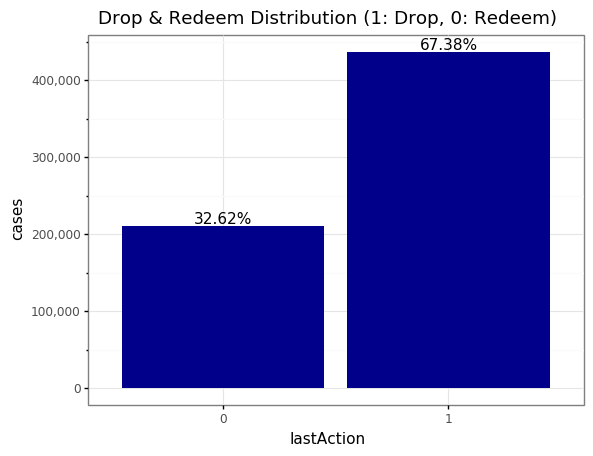

<ggplot: (355253053)>

In [64]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    group_by(X.lastAction) >>
    summarise(cases = n(X.lastAction)) >>
    mutate(pct = X.cases/len(datas_train)) >>
    ggplot() +
    geom_col(aes(x = 'lastAction', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Drop & Redeem Distribution (1: Drop, 0: Redeem)') +
    geom_text(aes(x = 'lastAction', y = 'cases', label = 'round(pct*100,2)'), va='bottom', format_string='{}%') +
    scale_y_continuous(labels = comma_format())
)

## Drop and Redeem Item Cond - Drop %

In [65]:
datas_train.columns.values

array(['MDMcustomerID', 'primaryLoan', 'originDate', 'antiquity_days',
       'store', 'CustomerZip_area', 'CustomerState',
       'distance_Cust_Store', 'LoanCount', 'loanExtensions', 'PUR',
       'lastAction', 'A_GM', 'B_GM', 'C_GM', 'N_GM', 'A_JW', 'B_JW',
       'C_JW', 'N_JW', 'CatDesc_q10_GM', 'CatDesc_q100_GM',
       'CatDesc_q2_GM', 'CatDesc_q20_GM', 'CatDesc_q30_GM',
       'CatDesc_q40_GM', 'CatDesc_q5_GM', 'CatDesc_q50_GM',
       'CatDesc_q60_GM', 'CatDesc_q70_GM', 'CatDesc_q80_GM',
       'CatDesc_q90_GM', 'CatDesc_q95_GM', 'CatDesc_q98_GM',
       'Other_CategoryDesc_GM', 'CatDesc_q10_JW', 'CatDesc_q100_JW',
       'CatDesc_q2_JW', 'CatDesc_q20_JW', 'CatDesc_q30_JW',
       'CatDesc_q40_JW', 'CatDesc_q5_JW', 'CatDesc_q50_JW',
       'CatDesc_q60_JW', 'CatDesc_q70_JW', 'CatDesc_q80_JW',
       'CatDesc_q90_JW', 'CatDesc_q95_JW', 'CatDesc_q98_JW',
       'Other_CategoryDesc_JW', 'total_original_price_GM',
       'total_original_price_JW', 'AVG_original_price_GM',
       '

In [66]:
a=(
datas_train >>
    group_by(X.lastAction) >>
    summarise(cases       = n(X.lastAction),
              item_cond_a_GM = if_else(X.A_GM == 0, 0, 1).sum(),
              item_cond_b_GM = if_else(X.B_GM == 0, 0, 1).sum(),
              item_cond_c_GM = if_else(X.C_GM == 0, 0, 1).sum(),
              item_cond_a_JW = if_else(X.A_JW == 0, 0, 1).sum(),
              item_cond_b_JW = if_else(X.B_JW == 0, 0, 1).sum(),
              item_cond_c_JW = if_else(X.C_JW == 0, 0, 1).sum()) >>
    ungroup >>
    mutate(sum_item_cond_a_GM = X.item_cond_a_GM.sum(),
           sum_item_cond_b_GM = X.item_cond_b_GM.sum(),
           sum_item_cond_c_GM = X.item_cond_c_GM.sum(),
           sum_item_cond_a_JW = X.item_cond_a_JW.sum(),
           sum_item_cond_b_JW = X.item_cond_b_JW.sum(),
           sum_item_cond_c_JW = X.item_cond_c_JW.sum())  >>
    mutate(A_GM = X.item_cond_a_GM/X.sum_item_cond_a_GM,
           B_GM = X.item_cond_b_GM/X.sum_item_cond_b_GM,
           C_GM = X.item_cond_c_GM/X.sum_item_cond_c_GM,
           A_JW = X.item_cond_a_JW/X.sum_item_cond_a_JW,
           B_JW = X.item_cond_b_JW/X.sum_item_cond_b_JW,
           C_JW = X.item_cond_c_JW/X.sum_item_cond_c_JW) >>
    select(X.lastAction,X.A_GM,X.B_GM,X.C_GM,X.A_JW,X.B_JW,X.C_JW) >>
    mask(X.lastAction == 1)
).T.reset_index()

a=a[a['index']!='lastAction']

a.columns = ['item_cond', 'drop_pct']

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 3 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_text : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


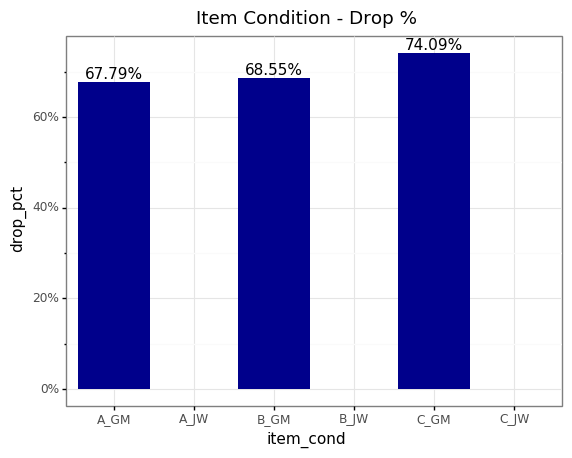

<ggplot: (330454981)>

In [67]:
(
a >>
    ggplot() +
    geom_col(aes(x = 'item_cond', y = 'drop_pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Item Condition - Drop %') +
    geom_text(aes(x = 'item_cond', y = 'drop_pct', label = 'round(drop_pct*100,2)'), va='bottom', format_string='{}%') +
    scale_y_continuous(labels = percent_format())
)

## Category Desc GM Cluster - Drop %

In [68]:
a=(
datas_train >>
    group_by(X.lastAction) >>
    summarise(cases       = n(X.lastAction),
              cases_CatDesc_q2 = if_else(X.CatDesc_q2_GM == 0, 0, 1).sum(),
              cases_CatDesc_q5 = if_else(X.CatDesc_q5_GM == 0, 0, 1).sum(),
              cases_CatDesc_q10 = if_else(X.CatDesc_q10_GM == 0, 0, 1).sum(),
              cases_CatDesc_q20 = if_else(X.CatDesc_q20_GM == 0, 0, 1).sum(),
              cases_CatDesc_q30 = if_else(X.CatDesc_q30_GM == 0, 0, 1).sum(),
              cases_CatDesc_q40 = if_else(X.CatDesc_q40_GM == 0, 0, 1).sum(),
              cases_CatDesc_q50 = if_else(X.CatDesc_q50_GM == 0, 0, 1).sum(),
              cases_CatDesc_q60 = if_else(X.CatDesc_q60_GM == 0, 0, 1).sum(),
              cases_CatDesc_q70 = if_else(X.CatDesc_q70_GM == 0, 0, 1).sum(),
              cases_CatDesc_q80 = if_else(X.CatDesc_q80_GM == 0, 0, 1).sum(),
              cases_CatDesc_q90 = if_else(X.CatDesc_q90_GM == 0, 0, 1).sum(),
              cases_CatDesc_q95 = if_else(X.CatDesc_q95_GM == 0, 0, 1).sum(),
              cases_CatDesc_q98 = if_else(X.CatDesc_q98_GM == 0, 0, 1).sum(),
              cases_CatDesc_q100 = if_else(X.CatDesc_q100_GM == 0, 0, 1).sum(),
              cases_Other_CategoryDesc = if_else(X.Other_CategoryDesc_GM == 0, 0, 1).sum()) >>
    ungroup >>
    mutate(sum_CatDesc_q2 = X.cases_CatDesc_q2.sum(),
           sum_CatDesc_q5 = X.cases_CatDesc_q5.sum(),
           sum_CatDesc_q10 = X.cases_CatDesc_q10.sum(),
           sum_CatDesc_q20 = X.cases_CatDesc_q20.sum(),
           sum_CatDesc_q30 = X.cases_CatDesc_q30.sum(),
           sum_CatDesc_q40 = X.cases_CatDesc_q40.sum(),
           sum_CatDesc_q50 = X.cases_CatDesc_q50.sum(),
           sum_CatDesc_q60 = X.cases_CatDesc_q60.sum(),
           sum_CatDesc_q70 = X.cases_CatDesc_q70.sum(),
           sum_CatDesc_q80 = X.cases_CatDesc_q80.sum(),
           sum_CatDesc_q90 = X.cases_CatDesc_q90.sum(),
           sum_CatDesc_q95 = X.cases_CatDesc_q95.sum(),
           sum_CatDesc_q98 = X.cases_CatDesc_q98.sum(),
           sum_CatDesc_q100 = X.cases_CatDesc_q100.sum(),
           sum_Other_CategoryDesc = X.cases_Other_CategoryDesc.sum()) >>
    
    mutate(CatDesc1_q2 = X.cases_CatDesc_q2/X.sum_CatDesc_q2,
           CatDesc2_q5 = X.cases_CatDesc_q5/X.sum_CatDesc_q5,
           CatDesc3_q10 = X.cases_CatDesc_q10/X.sum_CatDesc_q10,
           CatDesc4_q20 = X.cases_CatDesc_q20/X.sum_CatDesc_q20,
           CatDesc5_q30 = X.cases_CatDesc_q30/X.sum_CatDesc_q30,
           CatDesc6_q40 = X.cases_CatDesc_q40/X.sum_CatDesc_q40,
           CatDesc7_q50 = X.cases_CatDesc_q50/X.sum_CatDesc_q50,
           CatDesc8_q60 = X.cases_CatDesc_q60/X.sum_CatDesc_q60,
           CatDesc91_q70 = X.cases_CatDesc_q70/X.sum_CatDesc_q70,
           CatDesc92_q80 = X.cases_CatDesc_q80/X.sum_CatDesc_q80,
           CatDesc93_q90 = X.cases_CatDesc_q90/X.sum_CatDesc_q90,
           CatDesc94_q95 = X.cases_CatDesc_q95/X.sum_CatDesc_q95,
           CatDesc95_q98 = X.cases_CatDesc_q98/X.sum_CatDesc_q98,
           CatDesc9_q100 = X.cases_CatDesc_q100/X.sum_CatDesc_q100,
           Other_CategoryDesc = X.cases_Other_CategoryDesc/X.sum_Other_CategoryDesc) >>
    select(X.lastAction,
           X.CatDesc1_q2,
           X.CatDesc2_q5,
           X.CatDesc3_q10,
           X.CatDesc4_q20,
           X.CatDesc5_q30,
           X.CatDesc6_q40,
           X.CatDesc7_q50,
           X.CatDesc8_q60,
           X.CatDesc91_q70,
           X.CatDesc92_q80,
           X.CatDesc93_q90,
           X.CatDesc94_q95,
           X.CatDesc95_q98,
           X.CatDesc9_q100,
           X.Other_CategoryDesc
) >>
    mask(X.lastAction == 1)
).T.reset_index()

a=a[a['index']!='lastAction']

a.columns = ['CategoryDesc', 'drop_pct']

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


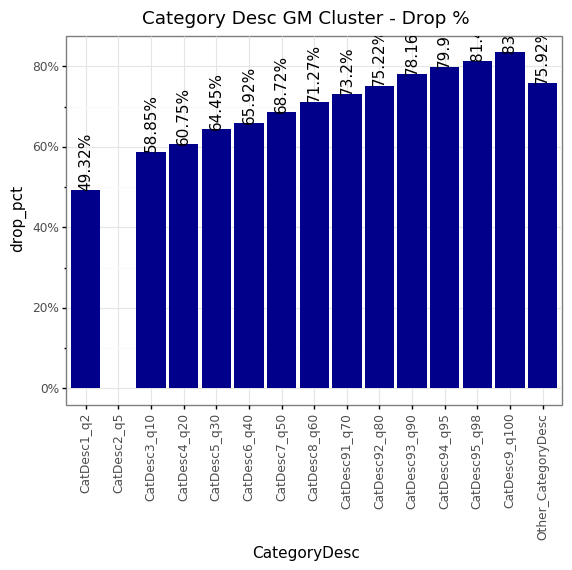

<ggplot: (330878305)>

In [69]:
(
a >>
    ggplot() +
    geom_col(aes(x = 'CategoryDesc', y = 'drop_pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Category Desc GM Cluster - Drop %') +
    geom_text(aes(x = 'CategoryDesc', y = 'drop_pct', label = 'round(drop_pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = percent_format())
)

## Category Desc JW Cluster - Drop %

In [70]:
a=(
datas_train >>
    group_by(X.lastAction) >>
    summarise(cases       = n(X.lastAction),
              cases_CatDesc_q2 = if_else(X.CatDesc_q2_JW == 0, 0, 1).sum(),
              cases_CatDesc_q5 = if_else(X.CatDesc_q5_JW == 0, 0, 1).sum(),
              cases_CatDesc_q10 = if_else(X.CatDesc_q10_JW == 0, 0, 1).sum(),
              cases_CatDesc_q20 = if_else(X.CatDesc_q20_JW == 0, 0, 1).sum(),
              cases_CatDesc_q30 = if_else(X.CatDesc_q30_JW == 0, 0, 1).sum(),
              cases_CatDesc_q40 = if_else(X.CatDesc_q40_JW == 0, 0, 1).sum(),
              cases_CatDesc_q50 = if_else(X.CatDesc_q50_JW == 0, 0, 1).sum(),
              cases_CatDesc_q60 = if_else(X.CatDesc_q60_JW == 0, 0, 1).sum(),
              cases_CatDesc_q70 = if_else(X.CatDesc_q70_JW == 0, 0, 1).sum(),
              cases_CatDesc_q80 = if_else(X.CatDesc_q80_JW == 0, 0, 1).sum(),
              cases_CatDesc_q90 = if_else(X.CatDesc_q90_JW == 0, 0, 1).sum(),
              cases_CatDesc_q95 = if_else(X.CatDesc_q95_JW == 0, 0, 1).sum(),
              cases_CatDesc_q98 = if_else(X.CatDesc_q98_JW == 0, 0, 1).sum(),
              cases_CatDesc_q100 = if_else(X.CatDesc_q100_JW == 0, 0, 1).sum(),
              cases_Other_CategoryDesc = if_else(X.Other_CategoryDesc_JW == 0, 0, 1).sum()) >>
    ungroup >>
    mutate(sum_CatDesc_q2 = X.cases_CatDesc_q2.sum(),
           sum_CatDesc_q5 = X.cases_CatDesc_q5.sum(),
           sum_CatDesc_q10 = X.cases_CatDesc_q10.sum(),
           sum_CatDesc_q20 = X.cases_CatDesc_q20.sum(),
           sum_CatDesc_q30 = X.cases_CatDesc_q30.sum(),
           sum_CatDesc_q40 = X.cases_CatDesc_q40.sum(),
           sum_CatDesc_q50 = X.cases_CatDesc_q50.sum(),
           sum_CatDesc_q60 = X.cases_CatDesc_q60.sum(),
           sum_CatDesc_q70 = X.cases_CatDesc_q70.sum(),
           sum_CatDesc_q80 = X.cases_CatDesc_q80.sum(),
           sum_CatDesc_q90 = X.cases_CatDesc_q90.sum(),
           sum_CatDesc_q95 = X.cases_CatDesc_q95.sum(),
           sum_CatDesc_q98 = X.cases_CatDesc_q98.sum(),
           sum_CatDesc_q100 = X.cases_CatDesc_q100.sum(),
           sum_Other_CategoryDesc = X.cases_Other_CategoryDesc.sum()) >>
    
    mutate(CatDesc1_q2 = X.cases_CatDesc_q2/X.sum_CatDesc_q2,
           CatDesc2_q5 = X.cases_CatDesc_q5/X.sum_CatDesc_q5,
           CatDesc3_q10 = X.cases_CatDesc_q10/X.sum_CatDesc_q10,
           CatDesc4_q20 = X.cases_CatDesc_q20/X.sum_CatDesc_q20,
           CatDesc5_q30 = X.cases_CatDesc_q30/X.sum_CatDesc_q30,
           CatDesc6_q40 = X.cases_CatDesc_q40/X.sum_CatDesc_q40,
           CatDesc7_q50 = X.cases_CatDesc_q50/X.sum_CatDesc_q50,
           CatDesc8_q60 = X.cases_CatDesc_q60/X.sum_CatDesc_q60,
           CatDesc91_q70 = X.cases_CatDesc_q70/X.sum_CatDesc_q70,
           CatDesc92_q80 = X.cases_CatDesc_q80/X.sum_CatDesc_q80,
           CatDesc93_q90 = X.cases_CatDesc_q90/X.sum_CatDesc_q90,
           CatDesc94_q95 = X.cases_CatDesc_q95/X.sum_CatDesc_q95,
           CatDesc95_q98 = X.cases_CatDesc_q98/X.sum_CatDesc_q98,
           CatDesc9_q100 = X.cases_CatDesc_q100/X.sum_CatDesc_q100,
           Other_CategoryDesc = X.cases_Other_CategoryDesc/X.sum_Other_CategoryDesc) >>
    select(X.lastAction,
           X.CatDesc1_q2,
           X.CatDesc2_q5,
           X.CatDesc3_q10,
           X.CatDesc4_q20,
           X.CatDesc5_q30,
           X.CatDesc6_q40,
           X.CatDesc7_q50,
           X.CatDesc8_q60,
           X.CatDesc91_q70,
           X.CatDesc92_q80,
           X.CatDesc93_q90,
           X.CatDesc94_q95,
           X.CatDesc95_q98,
           X.CatDesc9_q100,
           X.Other_CategoryDesc
) >>
    mask(X.lastAction == 1)
).T.reset_index()

a=a[a['index']!='lastAction']

a.columns = ['CategoryDesc', 'drop_pct']

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 6 rows containing missing values.
  data = self.position.setup_data(self.data, params)
//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


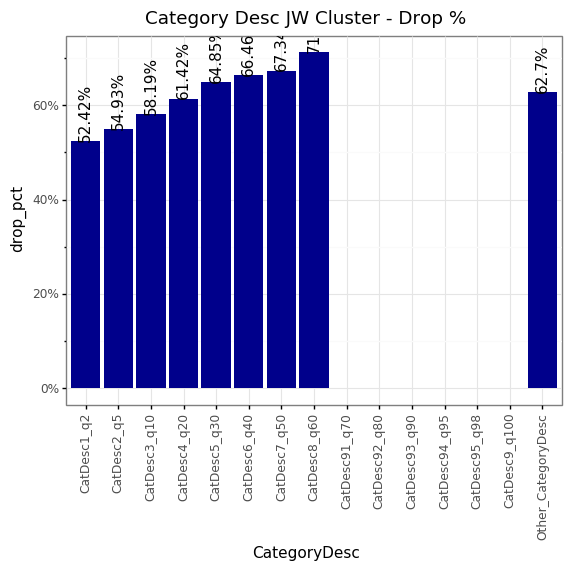

<ggplot: (318043565)>

In [71]:
(
a >>
    ggplot() +
    geom_col(aes(x = 'CategoryDesc', y = 'drop_pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Category Desc JW Cluster - Drop %') +
    geom_text(aes(x = 'CategoryDesc', y = 'drop_pct', label = 'round(drop_pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = percent_format())
)

## Loan Count - Drop %

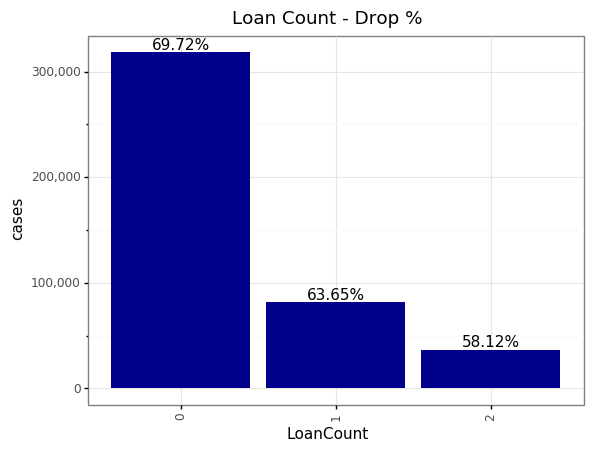

<ggplot: (355662209)>

In [72]:
(
datas_train >>
    group_by(X.LoanCount, X.lastAction) >>
    summarise(cases = n(X.LoanCount)) >>
    ungroup >>
    group_by(X.LoanCount) >>
    mutate(total = X.cases.sum()) >>
    ungroup >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1)  >>
    ggplot() +
    geom_col(aes(x = 'LoanCount', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Loan Count - Drop %') +
    geom_text(aes(x = 'LoanCount', y = 'cases', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = comma_format())  
)

## PUR Distribution - More than 1 loan

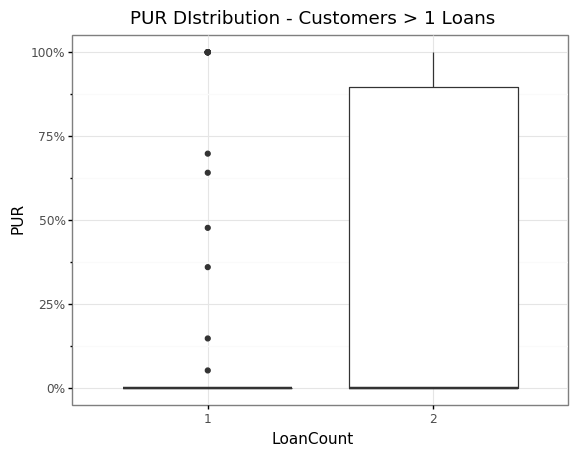

<ggplot: (355479025)>

In [73]:
(
datas_train.sample(10000) >>
    mutate(PUR = X.PUR.astype('float').fillna(0)) >>
    mask(X.LoanCount != '0') >>
    ggplot() +
    geom_boxplot(aes(x = 'LoanCount', y = 'PUR')) +
    theme_bw() +
    ggtitle('PUR DIstribution - Customers > 1 Loans') +
    scale_y_continuous(labels = percent_format())
)

## Month - Drop %

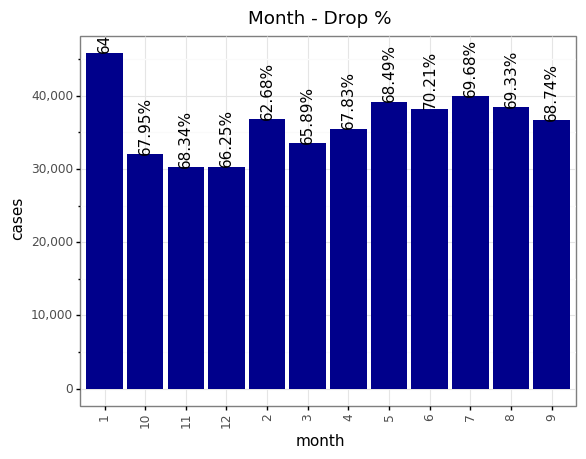

<ggplot: (355667653)>

In [74]:
(
datas_train >>
    group_by(X.month, X.lastAction) >>
    summarise(cases = n(X.month)) >>
    ungroup >>
    group_by(X.month) >>
    mutate(total = X.cases.sum()) >>
    ungroup >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1)  >>
    ggplot() +
    geom_col(aes(x = 'month', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Month - Drop %') +
    geom_text(aes(x = 'month', y = 'cases', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = comma_format())  
)

## Hour - Drop %

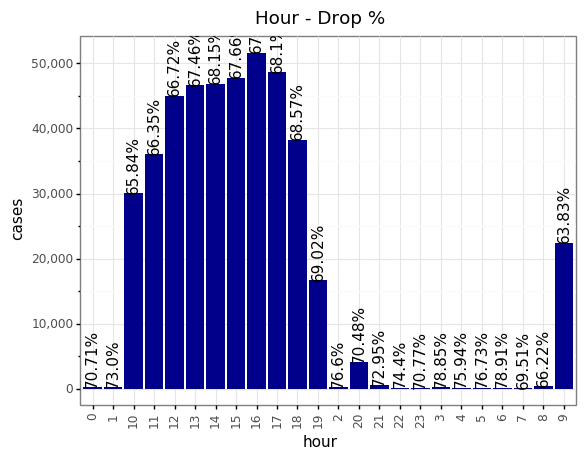

<ggplot: (367797017)>

In [75]:
(
datas_train >>
    group_by(X.hour, X.lastAction) >>
    summarise(cases = n(X.hour)) >>
    ungroup >>
    group_by(X.hour) >>
    mutate(total = X.cases.sum()) >>
    ungroup >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1)  >>
    ggplot() +
    geom_col(aes(x = 'hour', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Hour - Drop %') +
    geom_text(aes(x = 'hour', y = 'cases', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = comma_format())  
)

## Weekday - Drop %

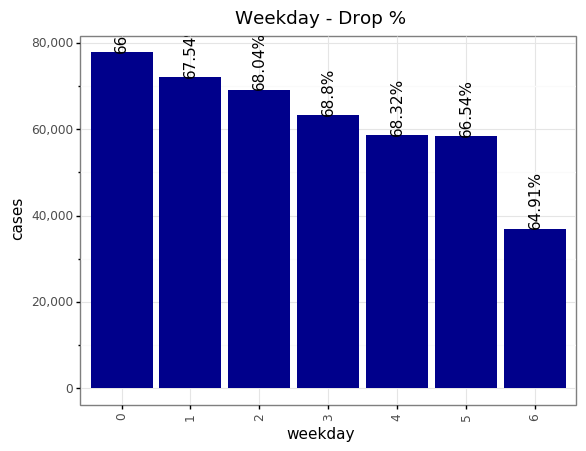

<ggplot: (330800489)>

In [76]:
(
datas_train >>
    group_by(X.weekday, X.lastAction) >>
    summarise(cases = n(X.weekday)) >>
    ungroup >>
    group_by(X.weekday) >>
    mutate(total = X.cases.sum()) >>
    ungroup >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1)  >>
    ggplot() +
    geom_col(aes(x = 'weekday', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Weekday - Drop %') +
    geom_text(aes(x = 'weekday', y = 'cases', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = comma_format())  
)

## State - Drop %

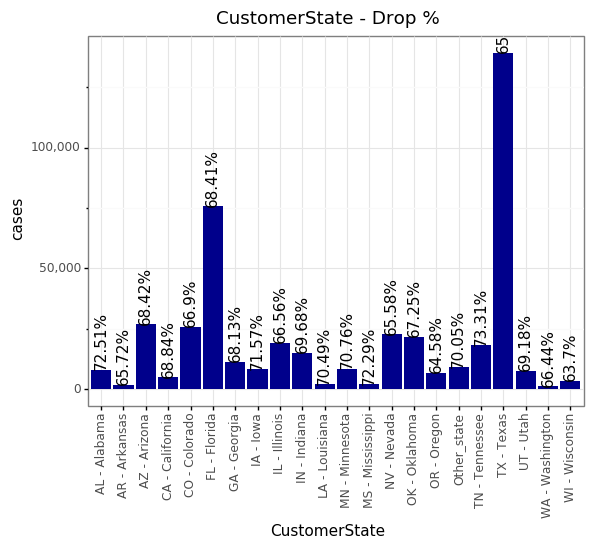

<ggplot: (356589657)>

In [77]:
(
datas_train >>
    group_by(X.CustomerState, X.lastAction) >>
    summarise(cases = n(X.CustomerState)) >>
    ungroup >>
    group_by(X.CustomerState) >>
    mutate(total = X.cases.sum()) >>
    ungroup >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1)  >>
    ggplot() +
    geom_col(aes(x = 'CustomerState', y = 'cases'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('CustomerState - Drop %') +
    geom_text(aes(x = 'CustomerState', y = 'cases', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    theme(axis_text_x = element_text(angle = 90)) +
    scale_y_continuous(labels = comma_format())  
)

## Antiquity Dristibution - LastAction

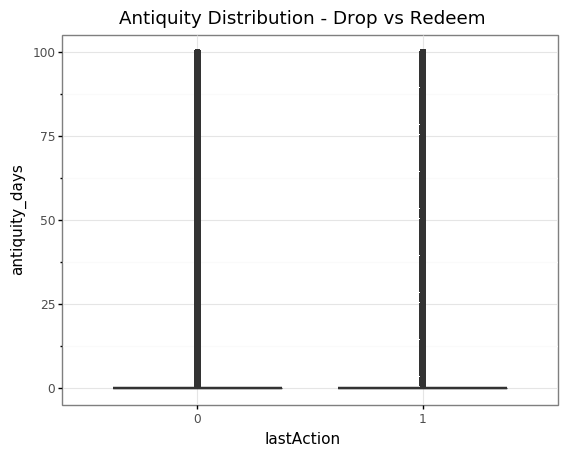

<ggplot: (364876905)>

In [78]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    mask(X.antiquity_days <= 100) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'antiquity_days')) +
    ggtitle('Antiquity Distribution - Drop vs Redeem') +
    theme_bw()
)

## Distance Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 72933 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


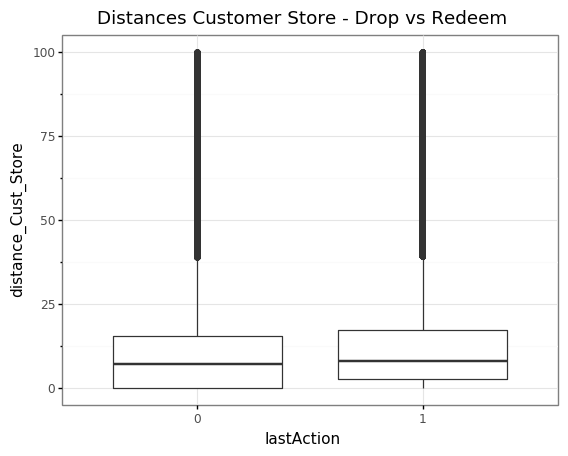

<ggplot: (372565917)>

In [79]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'distance_Cust_Store')) +
    ggtitle('Distances Customer Store - Drop vs Redeem') +
    theme_bw() +
    scale_y_continuous(limits = [0,100])
)

## Total Original Price GM Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 20443 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


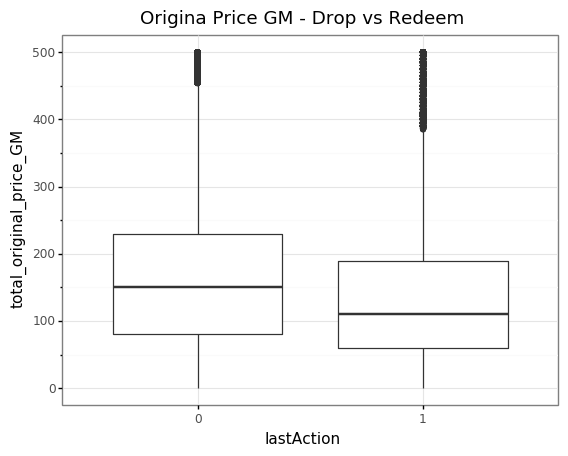

<ggplot: (379735073)>

In [80]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    mask(X.total_original_price_GM > 0) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'total_original_price_GM')) +
    ggtitle('Origina Price GM - Drop vs Redeem') +
    theme_bw() +
    scale_y_continuous(limits = [0,500])
)

## Total Original Price JW Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 33451 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


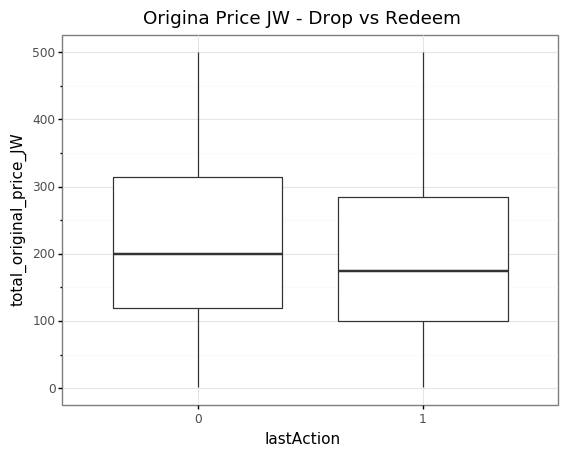

<ggplot: (383581977)>

In [81]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    mask(X.total_original_price_JW > 0) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'total_original_price_JW')) +
    ggtitle('Origina Price JW - Drop vs Redeem') +
    theme_bw() +
    scale_y_continuous(limits = [0,500])
)

## AVG Original Price GM Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 13699 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


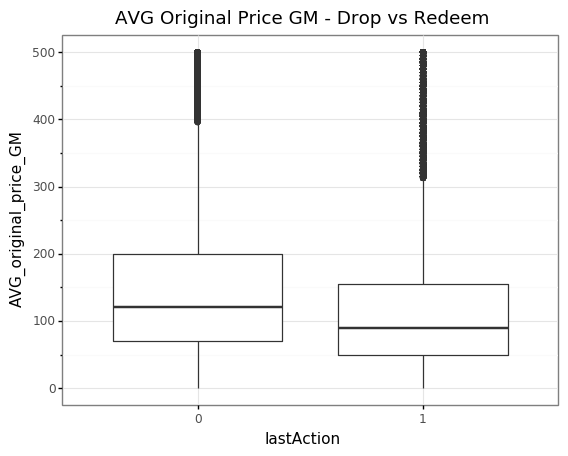

<ggplot: (385040565)>

In [82]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    mask(X.AVG_original_price_GM > 0) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'AVG_original_price_GM')) +
    ggtitle('AVG Original Price GM - Drop vs Redeem') +
    theme_bw() +
    scale_y_continuous(limits = [0,500])
)

## AVG Original Price JW Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 23093 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


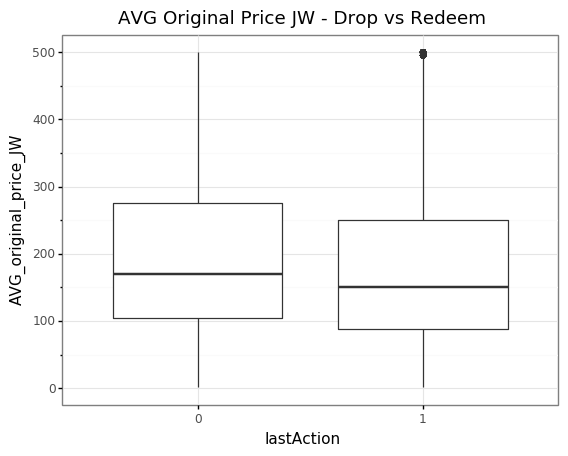

<ggplot: (389805333)>

In [83]:
(
datas_train >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    mask(X.AVG_original_price_JW > 0) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'AVG_original_price_JW')) +
    ggtitle('AVG Original Price JW - Drop vs Redeem') +
    theme_bw() +
    scale_y_continuous(limits = [0,500])
)

# COVID Descriptives

## Drop and Redeem % - Loans Originated in COVID

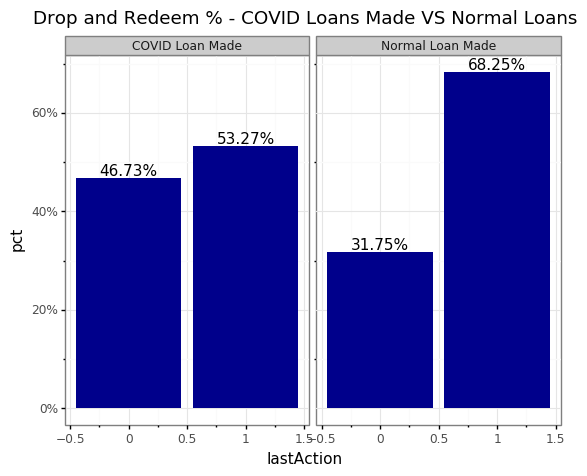

<ggplot: (389545097)>

In [84]:
(
datas_train >>
    mutate(COVID_LoanMade = if_else(X.COVID_LoanMade == 1,
                                    'COVID Loan Made',
                                    'Normal Loan Made')) >>
    group_by(X.COVID_LoanMade,X.lastAction) >>
    summarise(n = n(X.COVID_LoanMade)) >>
    ungroup >>
    group_by(X.COVID_LoanMade) >>
    mutate(total = X.n.sum()) >>
    mutate(pct = X.n/X.total) >>
    ggplot() +
    geom_col(aes(x = 'lastAction', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Drop and Redeem % - COVID Loans Made VS Normal Loans') +
    scale_y_continuous(labels = percent_format()) +
    geom_text(aes(x = 'lastAction', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    facet_wrap('~COVID_LoanMade')
)

## Drop and Redeem % - Loans Paid in COVID

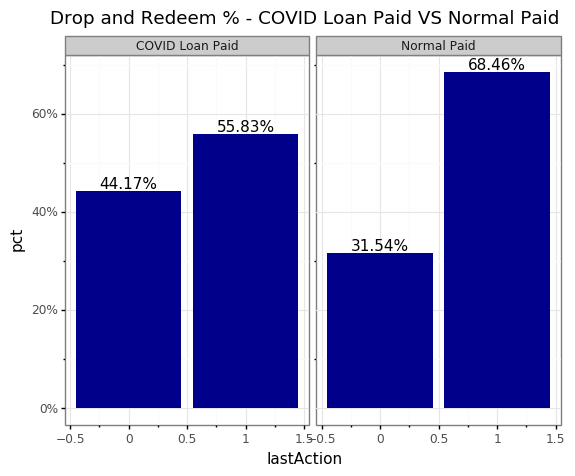

<ggplot: (385018537)>

In [85]:
(
datas_train >>
    mutate(COVID_LoanPaid = if_else(X.COVID_LoanPaid == 1,
                                    'COVID Loan Paid',
                                    'Normal Paid')) >>
    group_by(X.COVID_LoanPaid,X.lastAction) >>
    summarise(n = n(X.COVID_LoanPaid)) >>
    ungroup >>
    group_by(X.COVID_LoanPaid) >>
    mutate(total = X.n.sum()) >>
    mutate(pct = X.n/X.total) >>
    ggplot() +
    geom_col(aes(x = 'lastAction', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Drop and Redeem % - COVID Loan Paid VS Normal Paid') +
    scale_y_continuous(labels = percent_format()) +
    geom_text(aes(x = 'lastAction', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    facet_wrap('~COVID_LoanPaid')
)

## Hour Distribution - COVID Loans

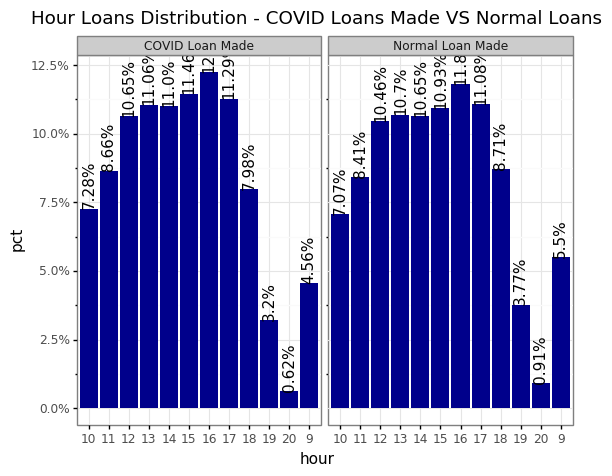

<ggplot: (376336149)>

In [86]:
(
datas_train >>
    mask(X.hour.isin(['9','10','11','12','13','14','15','16','17',
                     '18','19','20'])) >>
    mutate(COVID_LoanMade = if_else(X.COVID_LoanMade == 1,
                                    'COVID Loan Made',
                                    'Normal Loan Made')) >>
    group_by(X.COVID_LoanMade,X.hour) >>
    summarise(n = n(X.COVID_LoanMade)) >>
    ungroup >>
    group_by(X.COVID_LoanMade) >>
    mutate(total = X.n.sum()) >>
    mutate(pct = X.n/X.total) >>
    ggplot() +
    geom_col(aes(x = 'hour', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Hour Loans Distribution - COVID Loans Made VS Normal Loans') +
    scale_y_continuous(labels = percent_format()) +
    geom_text(aes(x = 'hour', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%', angle = 90) +
    facet_wrap('~COVID_LoanMade')
)

## Distance Distribution

//anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 72933 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


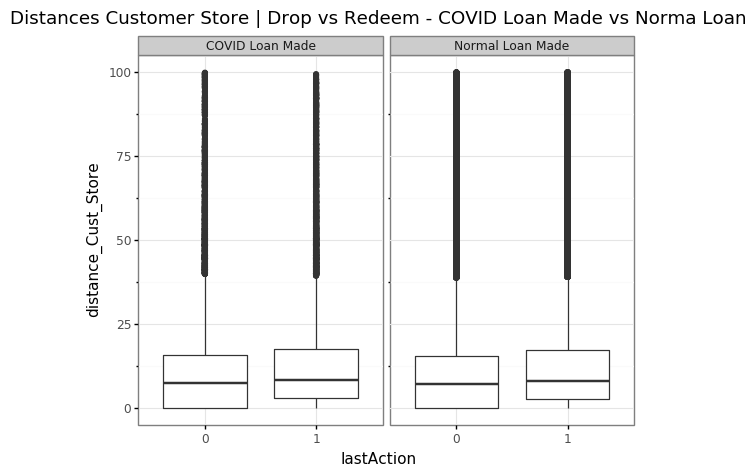

<ggplot: (385018805)>

In [87]:
(
datas_train >>
    mutate(COVID_LoanMade = if_else(X.COVID_LoanMade == 1,
                                    'COVID Loan Made',
                                    'Normal Loan Made')) >>
    mutate(lastAction = X.lastAction.astype('str')) >>
    ggplot() +
    geom_boxplot(aes(x = 'lastAction', y = 'distance_Cust_Store')) +
    ggtitle('Distances Customer Store | Drop vs Redeem - COVID Loan Made vs Norma Loan') +
    theme_bw() +
    scale_y_continuous(limits = [0,100]) +
    facet_wrap('~COVID_LoanMade')
)

# Fit LightGBM

Delete auxiliar objects to clean memory

In [88]:
del(datas)
del(Unique_Customer_Zip)
del(lat_tmp_Cust)
del(lon_tmp_Cust)
del(Customer_lat_lon)
del(Unique_Store_Zip)
del(lat_tmp_Store)
del(lon_tmp_Store)
del(Store_lat_lon)
del(first_loan_date)
del(CategoryDesc_pctDrop)
del(q2)
del(q5)
del(q10)
del(q20)
del(q30)
del(q40)
del(q50)
del(q60)
del(q70)
del(q80)
del(q90)
del(q95)
del(q98)
del(qs)
del(CategoryDesc_cluster)
del(CatDescClus)
del(group_features)
del(item_cond_data)
del(CatDesc_data)
del(cases_data)
del(good_states)

## X & Y

In [89]:
x = ['store','CustomerZip_area', 'primaryLoan',
     'distance_Cust_Store', 'LoanCount', 'antiquity_days',
     'loanExtensions', 'PUR', 'A_GM', 'B_GM', 'C_GM', 'N_GM', 'A_JW', 'B_JW',
       'C_JW', 'N_JW', 'CatDesc_q10_GM', 'CatDesc_q100_GM',
       'CatDesc_q2_GM', 'CatDesc_q20_GM', 'CatDesc_q30_GM',
       'CatDesc_q40_GM', 'CatDesc_q5_GM', 'CatDesc_q50_GM',
       'CatDesc_q60_GM', 'CatDesc_q70_GM', 'CatDesc_q80_GM',
       'CatDesc_q90_GM', 'CatDesc_q95_GM', 'CatDesc_q98_GM',
       'Other_CategoryDesc_GM', 'CatDesc_q10_JW', 'CatDesc_q100_JW',
       'CatDesc_q2_JW', 'CatDesc_q20_JW', 'CatDesc_q30_JW',
       'CatDesc_q40_JW', 'CatDesc_q5_JW', 'CatDesc_q50_JW',
       'CatDesc_q60_JW', 'CatDesc_q70_JW', 'CatDesc_q80_JW',
       'CatDesc_q90_JW', 'CatDesc_q95_JW', 'CatDesc_q98_JW',
       'Other_CategoryDesc_JW', 'total_original_price_GM',
       'total_original_price_JW', 'AVG_original_price_GM',
       'AVG_original_price_JW', 'num_items_GM', 'num_items_JW',
       'last_lastAction', 'month', 'hour', 'weekday', 'COVID_LoanMade',
       'COVID_LoanPaid','lastAction','originDate']

y = 'lastAction'

## One Hot Encoding

In [90]:
datas_train_d = pd.get_dummies(datas_train[x],columns=['store','CustomerZip_area',
                                                  'last_lastAction','month',
                                                  'hour','weekday','LoanCount'])

## Validation

Validation will be a 30% of the last 6 months data

In [91]:
valid=datas_train_d[datas_train_d['originDate']>='2019-11-01']

In [92]:
len(valid)

86759

In [93]:
aux, valid = train_test_split(valid,
                              test_size=0.3,
                              random_state=10)

In [94]:
len(valid)

26028

In [95]:
valid_PL = valid.primaryLoan.values

In [96]:
len(datas_train_d)

647769

In [97]:
datas_train_d = datas_train_d[~datas_train.primaryLoan.isin(valid_PL)]

In [98]:
len(datas_train_d)

621730

## One Hot Encoding

In [99]:
X_valid = valid.drop(columns=['primaryLoan','originDate','lastAction'])

In [100]:
y_valid = valid[y]

In [101]:
datas_train_x = datas_train_d.drop(columns=['primaryLoan','originDate','lastAction'])

In [102]:
datas_train_y = datas_train_d[y]

## Split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(datas_train_x,
                                                    datas_train_y,
                                                    test_size=0.4,
                                                    random_state=10)

In [104]:
len(X_train)

373038

In [105]:
len(X_test)

248692

In [106]:
len(X_valid)

26028

## Over sampling

In [107]:
rus = RandomOverSampler(return_indices=True, random_state=1)

In [108]:
X_train, y_train, id_rus = rus.fit_sample(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [109]:
X_train=pd.DataFrame(X_train)
X_train.columns=X_test.columns

In [110]:
y_train=y_train.tolist()
y_train=pd.DataFrame({'lastAction':y_train}).lastAction

In [111]:
#X_train=X_train.sample(1000,random_state=1)
#y_train=y_train.sample(1000,random_state=1)

In [112]:
len(X_train)

504672

In [113]:
y_train.value_counts()

1    252336
0    252336
Name: lastAction, dtype: int64

Train set in lightGBM correct format to fit the model

In [114]:
dX_train = lgb.Dataset(data = X_train, label = y_train.values)

In [115]:
gc.collect()

22282

In [116]:
gc.collect()

13121

In [117]:
gc.collect()

20

In [118]:
gc.collect()

20

## Metaparameters Search

Get the last model fitted

In [119]:
fit_params={"early_stopping_rounds": 30, 
            "eval_metric"          : 'auc', 
            "eval_set"             : [(X_test,y_test)],
            'eval_names'           : ['valid'],
            'verbose'              : 100}

In [120]:
param_test ={'num_leaves'       : sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample'        : sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree' : sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha'        : [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda'       : [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [121]:
n_HP_points_to_test = 500

In [122]:
clf = lgb.LGBMClassifier(max_depth     = -1,
                         random_state = 314,
                         silent       = True,
                         metric       = 'auc',
                         n_jobs       = 4,
                         n_estimators = 1000)

In [123]:
gs = RandomizedSearchCV(estimator           = clf,
                        param_distributions = param_test, 
                        n_iter              = n_HP_points_to_test,
                        scoring             = 'explained_variance',
                        cv                  = 3,
                        random_state        = 314)

In [124]:
cv_fit = gs.fit(X_train, y_train.values)

In [125]:
joblib.dump(cv_fit,"/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_GMJW_LGBM_Metaparameters_COVID.pkl")

['/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_GMJW_LGBM_Metaparameters_COVID.pkl']

In [126]:
print('Best score reached: {} with params: {} '.format(cv_fit.best_score_, cv_fit.best_params_))

Best score reached: -0.33344510146006856 with params: {'colsample_bytree': 0.8450583891155312, 'min_child_samples': 115, 'min_child_weight': 1, 'num_leaves': 49, 'reg_alpha': 5, 'reg_lambda': 1, 'subsample': 0.8004526451848355} 


In [127]:
opt_parameters = cv_fit.best_params_

## Fit

In [128]:
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(max_depth     = -1,
                         random_state = 314,
                         silent       = True,
                         metric       = 'auc',
                         n_jobs       = 12,
                         n_estimators = 1000)

In [130]:
#set optimal parameters
clf_final.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.8450583891155312, metric='auc',
               min_child_samples=115, min_child_weight=1, n_estimators=1000,
               n_jobs=12, num_leaves=49, random_state=314, reg_alpha=5,
               reg_lambda=1, subsample=0.8004526451848355)

In [442]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.5
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [132]:
#Train the final model with learning rate decay
clf_final.fit(X_train,
              y_train,
              **fit_params,
              callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid's auc: 0.700833


LGBMClassifier(colsample_bytree=0.8450583891155312, metric='auc',
               min_child_samples=115, min_child_weight=1, n_estimators=1000,
               n_jobs=12, num_leaves=49, random_state=314, reg_alpha=5,
               reg_lambda=1, subsample=0.8004526451848355)

In [133]:
joblib.dump(clf_final,"/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_GMJW_LGBM_BestModel_OS_COVID.pkl")

['/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_GMJW_LGBM_BestModel_OS_COVID.pkl']

In [124]:
#clf_final = joblib.load("/Users/darias/Documents/New_Customer_Model_V5/US/Pickles/US_GMJW_LGBM_BestModel_OS_COVID.pkl")

## Feature Importance

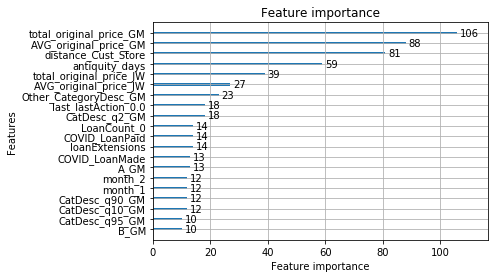

In [125]:
lgb.plot_importance(clf_final, max_num_features=20)

## Validation Data

In [126]:
y_est_proba = clf_final.predict_proba(X_valid, axis=1)
y_est_proba = pd.DataFrame(y_est_proba)
y_est_proba.columns = ['pred0','pred1']

In [127]:
versus=(
y_est_proba >>
    select(X.pred1) >>
    mutate(y_obs = y_valid.values)
)

versus.columns = ['y_est_proba', 'y_obs']

## Optimize Threshold

In [128]:
pred_t=y_est_proba.pred1
fpr, tpr, threshold = roc_curve(y_valid, pred_t)
index_max=(tpr-fpr).argmax()
opt=threshold[index_max] 

opt

0.3886192809816561

In [129]:
versus=(
versus >>
    mutate(y_est = if_else(X.y_est_proba >= opt, 1, 0))
)

## Model Performance

In [130]:
# Confussion Matrix
cm_opt_v = confusion_matrix(versus.y_est,y_valid.values)

# Accuracy
accuracy_opt_v=accuracy_score(versus.y_est,y_valid)

# AUC
auc_opt_v = roc_auc_score(y_valid,versus.y_est)

### Confusion Matrix

In [131]:
cm_opt_v

array([[ 6275,  4156],
       [ 4128, 11469]])

### Accuracy

In [132]:
accuracy_opt_v

0.681727370524051

### AUC

In [133]:
auc_opt_v

0.6686036935499375

### Classification Report

In [134]:
print(classification_report(versus.y_est,y_valid.values))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     10431
           1       0.73      0.74      0.73     15597

    accuracy                           0.68     26028
   macro avg       0.67      0.67      0.67     26028
weighted avg       0.68      0.68      0.68     26028



## GM Performance

Performance for loans with only GM items

In [135]:
aux = (
X_valid >>
    mutate(pred = versus.y_est.values,
           obs  = y_valid.values) >>
    mask(X.num_items_GM > 0, X.num_items_JW == 0)
)

In [136]:
# Confussion Matrix
cm_opt_v = confusion_matrix(aux.pred,aux.obs.values)

# Accuracy
accuracy_opt_v=accuracy_score(aux.pred,aux.obs.values)

# AUC
auc_opt_v = roc_auc_score(aux.pred,aux.obs.values)

### Confusion Matrix

In [137]:
cm_opt_v

array([[4045, 2691],
       [2973, 8695]])

### Accuracy

In [138]:
accuracy_opt_v

0.6922408172136492

### AUC

In [139]:
auc_opt_v

0.672852649551283

### Classification Report

In [140]:
print(classification_report(aux.pred,aux.obs.values))

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      6736
           1       0.76      0.75      0.75     11668

    accuracy                           0.69     18404
   macro avg       0.67      0.67      0.67     18404
weighted avg       0.70      0.69      0.69     18404



## JW Performance

Performance for loans with only JW items

In [141]:
aux = (
X_valid >>
    mutate(pred = versus.y_est.values,
           obs  = y_valid.values) >>
    mask(X.num_items_JW > 0, X.num_items_GM == 0)
)

In [142]:
# Confussion Matrix
cm_opt_v = confusion_matrix(aux.pred,aux.obs.values)

# Accuracy
accuracy_opt_v=accuracy_score(aux.pred,aux.obs.values)

# AUC
auc_opt_v = roc_auc_score(aux.pred,aux.obs.values)

### Confusion Matrix

In [143]:
cm_opt_v

array([[2151, 1423],
       [1095, 2640]])

### Accuracy

In [144]:
accuracy_opt_v

0.6554932275277056

### AUC

In [145]:
auc_opt_v

0.6543369898171308

### Classification Report

In [146]:
print(classification_report(aux.pred,aux.obs.values))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63      3574
           1       0.65      0.71      0.68      3735

    accuracy                           0.66      7309
   macro avg       0.66      0.65      0.65      7309
weighted avg       0.66      0.66      0.65      7309



## Mix Performance

Performance just for loans with GM & JW items

In [147]:
aux = (
X_valid >>
    mutate(pred = versus.y_est.values,
           obs  = y_valid.values) >>
    mask(X.num_items_JW > 0, X.num_items_GM > 0)
)

In [148]:
# Confussion Matrix
cm_opt_v = confusion_matrix(aux.pred,aux.obs.values)

# Accuracy
accuracy_opt_v=accuracy_score(aux.pred,aux.obs.values)

# AUC
auc_opt_v = roc_auc_score(aux.pred,aux.obs.values)

### Confusion Matrix

In [149]:
cm_opt_v

array([[ 79,  42],
       [ 60, 134]])

### Accuracy

In [150]:
accuracy_opt_v

0.6761904761904762

### AUC

In [231]:
auc_opt_v

0.6718071057340037

### Classification Report

In [232]:
print(classification_report(aux.pred,aux.obs.values))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61       121
           1       0.76      0.69      0.72       194

    accuracy                           0.68       315
   macro avg       0.66      0.67      0.67       315
weighted avg       0.69      0.68      0.68       315



## Partial Plots - Top 5

Function that plot a marginal effect

In [144]:
def partial_plot(model,frame,feature):
    df_aux=frame.copy()
    df_aux[feature]=X_train[feature].quantile(
        q=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,
           0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
       ).values
    p=pd.DataFrame(clf_final.predict_proba(df_aux))
    p.columns = ['pred0','pred1']
    df_aux['mean_response']=p.pred1
    pplot=(
        df_aux >>
        distinct(feature) >>
        ggplot() +
        ggtitle(feature+' - Partial Plot') +
        theme_bw() +
        scale_y_continuous(labels = percent_format()) +
        geom_line(aes(x = feature, y = 'mean_response'), colour='darkblue')
        )
#    if len(df_aux[feature].unique()) < 40:
#        pplot=(
#        df_aux >>
#        distinct(X.num_store_Mexico) >>
#        ggplot() +
#        ggtitle(feature+' - Partial Plot') +
#        theme_bw() +
#        scale_y_continuous(labels = percent_format()) +
#        geom_line(aes(x = feature, y = 'mean_response'), colour='darkblue')
#        )
#    else:
#        pplot=(
#        df_aux >>
#        ggplot() +
#        ggtitle(feature+' - Partial Plot') +
#        theme_bw() +
#        scale_y_continuous(labels = percent_format()) +
#        geom_smooth(aes(x = feature, y = 'mean_response'), colour='darkblue')
#        )
    return(pplot)

Df with the mean of all features to create the marginal effects

In [145]:
avg_frame_opt=X_train.mean(axis=0).to_frame().T
avg_frame_opt_20=pd.DataFrame(np.repeat(avg_frame_opt.values,21,axis=0))
avg_frame_opt_20.columns = avg_frame_opt.columns

Top 5 features in a vector

In [152]:
top10_opt=['total_original_price_GM','AVG_original_price_GM','distance_Cust_Store',
'antiquity_days','total_original_price_JW',
           'COVID_LoanMade','COVID_LoanPaid']

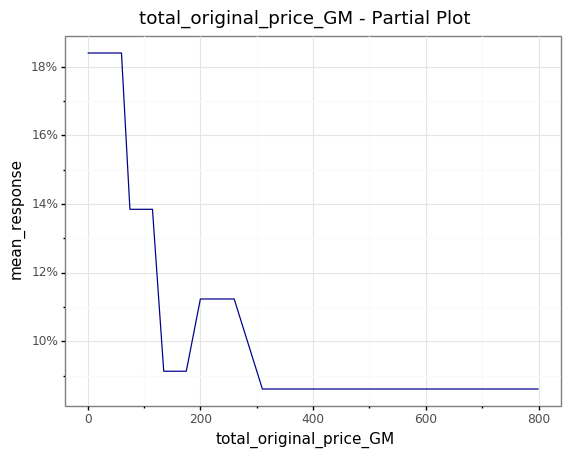

<ggplot: (394355921)>

In [147]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[0])

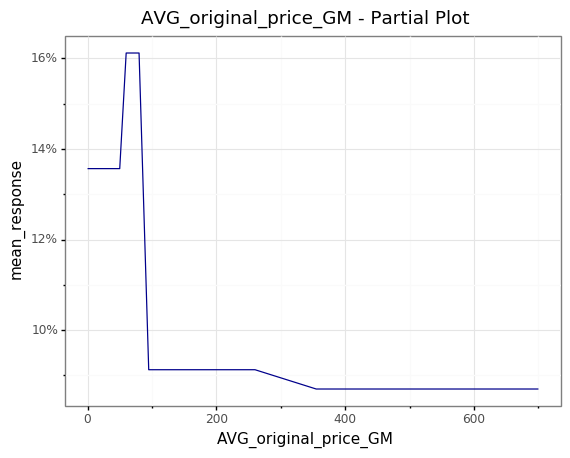

<ggplot: (375863541)>

In [148]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[1])

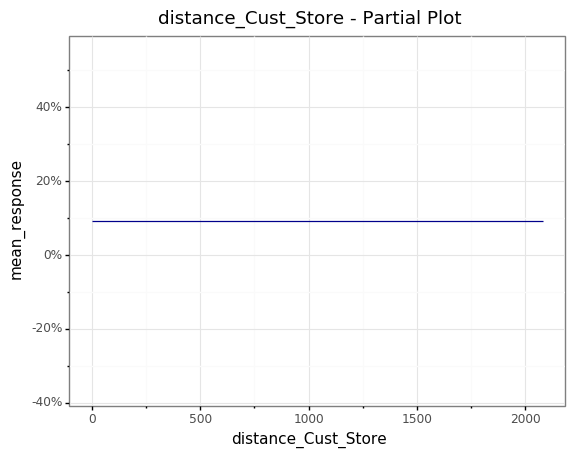

<ggplot: (360870829)>

In [149]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[2])

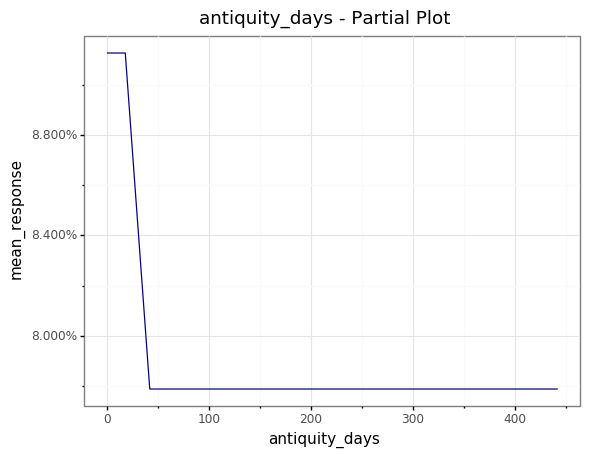

<ggplot: (360851921)>

In [150]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[3])

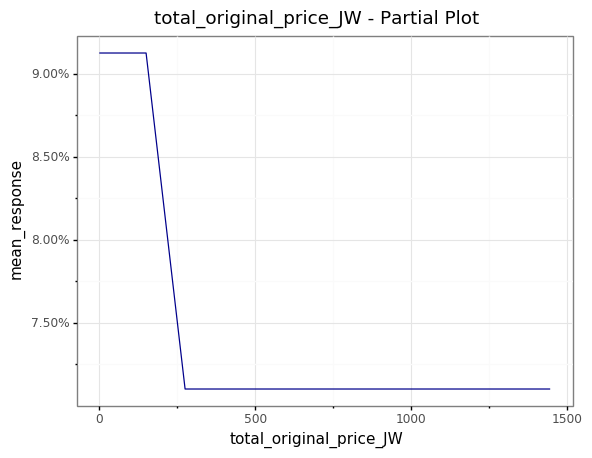

<ggplot: (352039429)>

In [153]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[4])

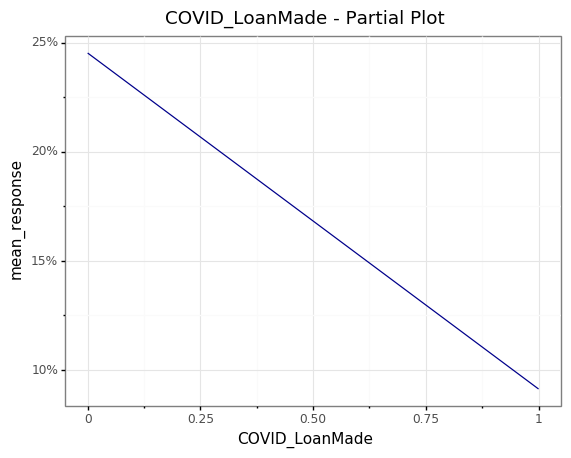

<ggplot: (381684085)>

In [154]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[5])

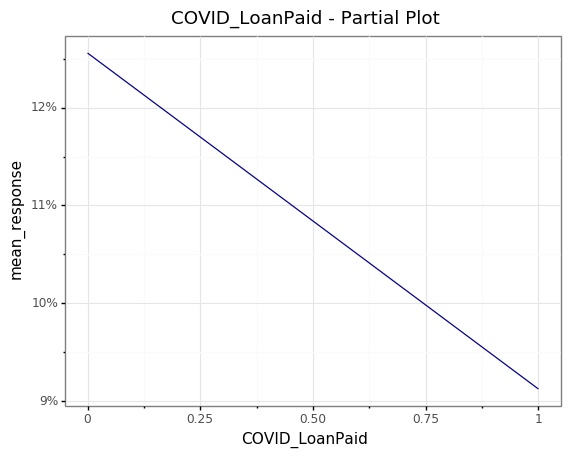

<ggplot: (336308297)>

In [155]:
partial_plot(clf_final,avg_frame_opt_20,top10_opt[6])

## Efectiveness

Back testing in the _validation_ frame

In [151]:
predict_ = y_est_proba.pred1

In [152]:
predict_ = y_est_proba.pred1

predict_efect = pd.DataFrame([predict_.values, y_valid.values]).T

predict_efect.columns = ['predict', 'y_red']

predict_efect['r_score'] = pd.qcut(predict_efect.predict, q=[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,
                                                         0.7,0.8,0.9,1.0], 
                                   labels=['q10%','q20%','q30%','q40%','q50%','q60%','q70%','q80%','q90%','q100%'])

a = predict_efect.loc[predict_efect.y_red == 1].groupby(['r_score']).y_red.count() /predict_efect.groupby(['r_score']).y_red.count()

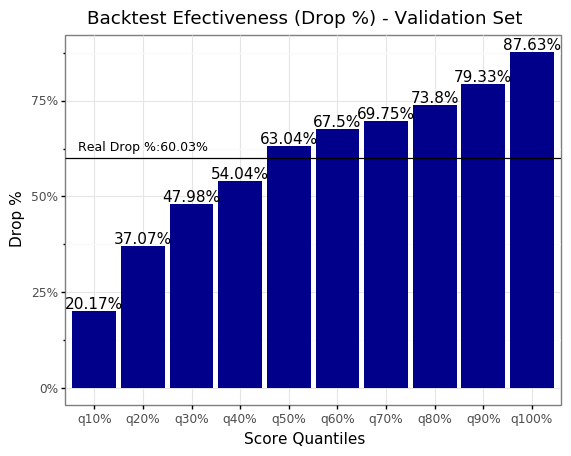

<ggplot: (384804473)>

In [153]:
(pd.DataFrame(a).reset_index() >>
 ggplot() +
 geom_col(aes(x = 'r_score', y = 'y_red'), fill = 'darkblue') +
 theme_bw() +
 ggtitle('Backtest Efectiveness (Drop %) - Validation Set') +
 geom_text(aes(x = 'r_score', y = 'y_red', label = 'round(y_red*100,2)'),
           va='bottom', format_string='{}%') +
 scale_y_continuous(labels = percent_format()) +
 ylab('Drop %') +
 xlab('Score Quantiles') +
 geom_hline(yintercept = y_valid.mean()) +
 annotate('text',
          x    = 'q20%',
          y    = y_valid.mean()+0.03,
          label = 'Real Drop %:'+ round((y_valid.mean())*100,2).astype('str')+'%',
          size = 9)
)

## ALG (PUR) Efectiveness

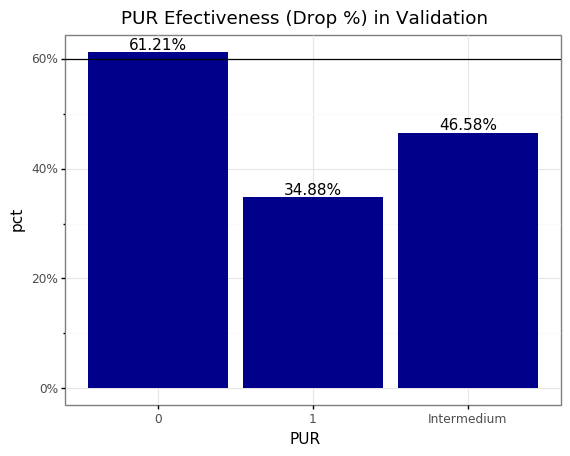

<ggplot: (379731545)>

In [154]:
(
X_valid >>
    mutate(score = y_est_proba.pred1,
           lastAction = y_valid.values,
           PUR        = if_else(X.PUR == 0, '0',
                                if_else(X.PUR == 1, '1', 'Intermedium'))) >>
    group_by(X.PUR, X.lastAction) >>
    summarise(cases = n(X.PUR)) >>
    ungroup >>
    group_by(X.PUR) >>
    mutate(total = X.cases.sum()) >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1) >>
    ggplot() +
    geom_col(aes(x = 'PUR', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('PUR Efectiveness (Drop %) in Validation') +
    geom_text(aes(x = 'PUR', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    scale_y_continuous(labels = percent_format()) +
    geom_hline(yintercept = y_valid.mean())
)

## ALG Efectiveness - Customer Bucket

In [155]:
valid = (
    X_valid >>
    mutate(lastAction = y_valid.values,
           score      = predict_.values)
)

In [156]:
datas_train_aux = datas_train.loc[X_valid.index]

In [157]:
valid['MDMcustomerID']=datas_train_aux['MDMcustomerID']
valid['primaryLoan']=datas_train_aux['primaryLoan']

In [158]:
group_features2 = ['MDMcustomerID', 'primaryLoan',
                   'pos2_Bucket', 'loanAmt_allItems',
                   'originDate','posLoanReqId',
                   'lastActionDate','loanPSC','PUR_Bucket']

In [159]:
datas = pd.read_csv('/Users/darias/Documents/New_Customer_Model_V5/US/Data_In/US_GMJW_NewCustomer_Data.csv',sep=",")
CustBuck = (
datas[group_features2] >>
    distinct
)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,41,91,93,94,95,98,99,102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [160]:
valid = valid.merge(CustBuck,
                    on = ['MDMcustomerID', 'primaryLoan'],
                    how = 'left')

In [161]:
len(valid)

26043

For loans that have a posloanreqid pur_bucket should be populated and is the correct source. For loans that were pos1 or did not call DE, pur_bucket will show ‘error’ and you can use pos2_bucket.

In [162]:
valid['posLoanReqId'] = valid.posLoanReqId.fillna('NoPosReqId')

In [163]:
valid=(
valid >>
    mutate(ALG_bucket = if_else(X.posLoanReqId == 'NoPosReqId',
                                X.pos2_Bucket,X.PUR_Bucket))
)

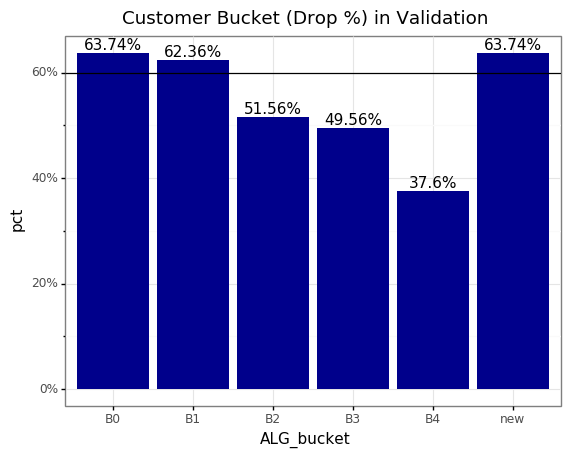

<ggplot: (316033437)>

In [164]:
(
valid >>
    group_by(X.ALG_bucket, X.lastAction) >>
    summarise(cases = n(X.ALG_bucket)) >>
    ungroup >>
    group_by(X.ALG_bucket) >>
    mutate(total = X.cases.sum()) >>
    mutate(pct = X.cases/X.total) >>
    mask(X.lastAction == 1) >>
    ggplot() +
    geom_col(aes(x = 'ALG_bucket', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Customer Bucket (Drop %) in Validation') +
    geom_text(aes(x = 'ALG_bucket', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    scale_y_continuous(labels = percent_format()) +
    geom_hline(yintercept = y_valid.mean())
)

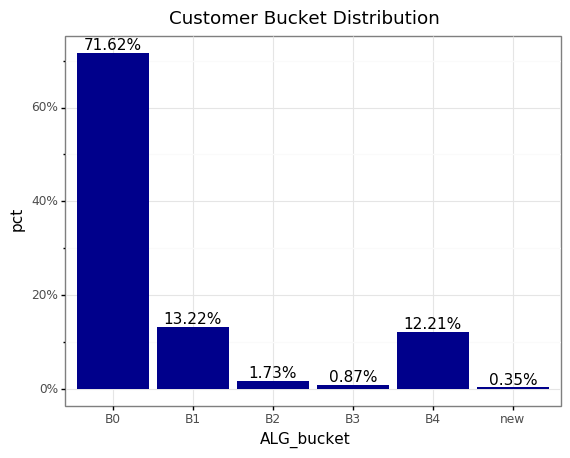

<ggplot: (305999601)>

In [165]:
(
valid >>
    group_by(X.ALG_bucket) >>
    summarise(cases = n(X.ALG_bucket)) >>
    mutate(pct = X.cases/len(valid)) >>
    ggplot() +
    geom_col(aes(x = 'ALG_bucket', y = 'pct'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Customer Bucket Distribution') +
    geom_text(aes(x = 'ALG_bucket', y = 'pct', label = 'round(pct*100,2)'),
              va='bottom', format_string='{}%') +
    scale_y_continuous(labels = percent_format())
)

## ALG Accuracy

Calculate the ALG Accuracy, using the drop prediction as this:
 - New, B1 and B2: Drop
 - B3, B4: Redeem

In [166]:
alg_real = (
valid >>
    mask(X.ALG_bucket != 'error')
)
alg_real=alg_real['lastAction'].values.tolist()

alg_pred = (
valid >>
    mask(X.ALG_bucket != 'error') >>
    mutate(aux = if_else(X.ALG_bucket.isin(['new', 'B1', 'B2']), 1, 0))
)
alg_pred=alg_pred['aux'].values.tolist()

In [157]:
accuracy_score(alg_pred,alg_real)

0.433897784433437

## ALG AUC

In [158]:
roc_auc_score(alg_real,alg_pred)

0.5036405383498405

## ALG Classification Report

In [159]:
print(classification_report(alg_pred,alg_real))

              precision    recall  f1-score   support

           0       0.85      0.40      0.55     22059
           1       0.16      0.61      0.25      3984

    accuracy                           0.43     26043
   macro avg       0.50      0.51      0.40     26043
weighted avg       0.74      0.43      0.50     26043



# Spreadsheet data - CG vs ALG

In [205]:
ss = (
valid >>
    select(X.posLoanReqId,X.originDate,X.primaryLoan,X.MDMcustomerID,X.ALG_bucket,
           X.total_original_price_GM,X.total_original_price_JW,X.loanAmt_allItems,X.lastAction,X.score,
           X.lastActionDate,X.loanPSC)
)

In [206]:
ss=(
ss >>
    mutate(ALG_prediction       = if_else(X.ALG_bucket.isin(['new', 'B1', 'B2']), 'Drop', 'Redeem'),
           CG_prediction        = if_else(X.score >= opt, 'Drop', 'Redeem'),
           total_original_price = X.total_original_price_GM+X.total_original_price_JW)
)

In [207]:
ss['originDate']=pd.to_datetime(ss['originDate'])
ss['lastActionDate']=pd.to_datetime(ss['lastActionDate'])
ss['duration'] = ss['lastActionDate'] - ss['originDate']
ss['duration']=ss['duration'].dt.days

ss['originDate']=ss['originDate'].astype('str')
ss['lastActionDate']=ss['lastActionDate'].astype('str')

In [208]:
ss=(
ss >>
    mutate(TP_CG = if_else((X.CG_prediction == 'Drop')   & (X.lastAction == 1), 1, 0)) >>
    mutate(TN_CG = if_else((X.CG_prediction == 'Redeem') & (X.lastAction == 0), 1, 0)) >>
    mutate(FP_CG = if_else((X.CG_prediction == 'Drop')   & (X.lastAction == 0), 1, 0)) >>
    mutate(FN_CG = if_else((X.CG_prediction == 'Redeem') & (X.lastAction == 1), 1, 0)) >>

    mutate(TP_ALG = if_else((X.ALG_prediction == 'Drop')   & (X.lastAction == 1), 1, 0)) >>
    mutate(TN_ALG = if_else((X.ALG_prediction == 'Redeem') & (X.lastAction == 0), 1, 0)) >>
    mutate(FP_ALG = if_else((X.ALG_prediction == 'Drop')   & (X.lastAction == 0), 1, 0)) >>
    mutate(FN_ALG = if_else((X.ALG_prediction == 'Redeem') & (X.lastAction == 1), 1, 0))
)

In [209]:
ss=(
ss >>
    select(X.originDate,X.primaryLoan,X.MDMcustomerID,X.ALG_bucket,
           X.total_original_price_GM,X.total_original_price_JW,
           X.total_original_price,X.loanAmt_allItems,X.lastAction,
           X.ALG_prediction,X.CG_prediction,
           X.duration, X.loanPSC,
           X.TP_CG,X.TN_CG,X.FP_CG,X.FN_CG,
           X.TP_ALG,X.TN_ALG,X.FP_ALG,X.FN_ALG)
)

In [210]:
ss.rename(columns={'loanAmt_allItems':'loan_amount',
                   'lastAction':'actual_outcome'}, 
                 inplace=True)

In [211]:
ss.to_excel("/Users/darias/Downloads/US_GMJW_AlgCg_comparison.xlsx") 

# LTV

## LTV Real vs Drop %

Calculate the Real LTV, and get the Drop% for each LTV decile

$$LTVReal_{Loan} = \frac{LoanAmt_{Loan}}{OriginalPrice_{Loan}}$$

In [167]:
valid['LTV_Real']=valid['loanAmt_allItems']/(valid.total_original_price_GM+valid.total_original_price_JW)

Calculate the Drop% per deciles

In [168]:
LTV_efect = pd.DataFrame([valid.LTV_Real, valid.lastAction]).T

LTV_efect.columns = ['LTV', 'lastAction']

LTV_efect['decile'] = pd.qcut(LTV_efect.LTV, q=[0.0,0.1,0.2,0.3,0.4,0.5,
                                                     0.6,0.7,0.8,0.9,1.0], 
                                   labels=['q10%','q20%','q30%','q40%','q50%','q60%',
                                           'q70%','q80%','q90%','q100%'])

a = LTV_efect.loc[LTV_efect.lastAction == 1].groupby(['decile']).lastAction.count()/LTV_efect.groupby(['decile']).lastAction.count()

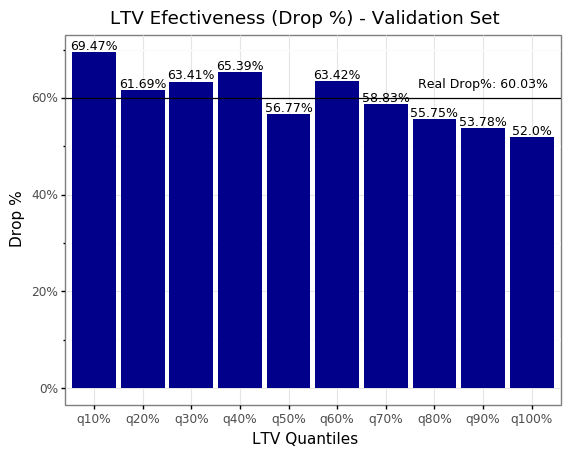

<ggplot: (316032709)>

In [169]:
(pd.DataFrame(a).reset_index() >>
 ggplot() +
 geom_col(aes(x = 'decile', y = 'lastAction'), fill = 'darkblue') +
 theme_bw() +
 ggtitle('LTV Efectiveness (Drop %) - Validation Set') +
 geom_text(aes(x = 'decile', y = 'lastAction', label = 'round(lastAction*100,2)'),
           va='bottom', format_string='{}%', size = 9) +
 scale_y_continuous(labels = percent_format()) +
 ylab('Drop %') +
 xlab('LTV Quantiles') +
 geom_hline(yintercept = y_valid.mean()) +
 annotate('text',
          x    = 'q90%',
          y    = valid.lastAction.mean()+0.03,
          label = 'Real Drop%: '+ round((valid.lastAction.mean())*100,2).astype('str')+'%',
          size = 9)
)

## LTV vs PSC

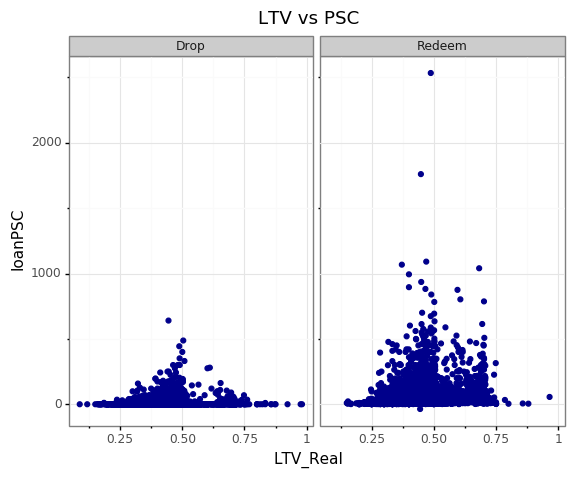

<ggplot: (315999037)>

In [170]:
(
valid >>
    mask(X.LTV_Real<1) >>
    mutate(lastAction = if_else(X.lastAction == 1, 'Drop', 'Redeem')) >>
    ggplot() +
    geom_point(aes(x = 'LTV_Real', y = 'loanPSC'), colour = 'darkblue') +
    ggtitle('LTV vs PSC') +
    theme_bw() +
    facet_wrap('~lastAction')
)

## LTV vs PSC %

PSC% = PSC/LoanAmt

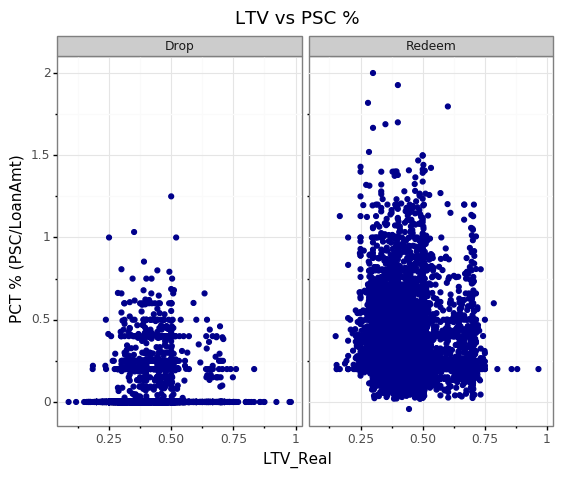

<ggplot: (313763449)>

In [164]:
(
valid >>
    mask(X.LTV_Real<1) >>
    mutate(lastAction = if_else(X.lastAction == 1, 'Drop', 'Redeem'),
           PCT_pct    = X.loanPSC/X.loanAmt_allItems) >>
    ggplot() +
    geom_point(aes(x = 'LTV_Real', y = 'PCT_pct'), colour = 'darkblue') +
    ggtitle('LTV vs PSC %') +
    theme_bw() +
    facet_wrap('~lastAction') +
    ylab('PCT % (PSC/LoanAmt)')
)

## Simulation - Real Last Action

We want to optimize the LTV for each score decile.

For this, we need first to know the **gain** for the 2 **Last Action** scenarios:

|  Last Action  |                  Gain                  |
|:-------------:|:--------------------------------------:|
|     Drop      |             PSC + Sale Gain*           |
|    Redeem     |                  PSC                   |

$\text{Sale Gain}_{Loan} = SoldPrice_{Loan} - LoanAmount_{Loan}$

### PSC Expected - Explanation

**PSC:** The PSC that a customer will give to the company at the moment of the loan origination, cannot be known, but we can get the % of the PSC paid in function of the Loan Amount, so in the simulation we can play with differents Loan Amounts and get a PSC expected for each loan.

$PscRatio_{Loan} = \frac{PSC_{Loan}}{LoanAmount_{Loan}}$

In this formula, we are assuming that the time to close the loan is not affected by the LTV

$LoanAmountExpected_{Loan} = {LTVSimulated_{ScoreDecile}}*{OriginalPrice_{Loan}}$

$PscExpected_{Loan} = PscRatio_{Loan}*LoanAmountExpected_{Loan}$

### Sale Price Expected - Explanation

**Sale Price:** Also we cannot know the sale price that an item will have, because the sale price can be different along the time, based on two principal reasons:
 - Time to sale the item
 - Item category

When an item takes more time to sale, then a bigger discount is going to have, and the discount % is differente for each category.

So, to have an approach of a **sold price expected**, it will be calculated the average of the % discount for each **Category Description**, for **items sold in the last 6 months**.

$DiscountPCT_{CategoryDesc} = \overline{\frac{SoldPrice_{CategoryDesc}}{OriginalPrice_{CategoryDesc}}}$

$\text{Sale Gain}_{Loan} = OriginalPrice_{Loan}*DiscountPCT_{CategoryDesc} - LoanAmountExpected_{Loan}$

## LTV Simulation

The PSC and Sold Price Expected will be calculated with different LTVs for each decile, to optimize wich LTVs maximize the *Total Gain* and maximize the *VaR*

$VaR_{LTV}=Z*TotalGainExpected_{LTV}*\sigma_{LTV}*t^{1/2}$

For this excercise:
 - $Z_{0.95} = 1.64$
 - TotalGainExpected = $\sum GainExpected_{LTV}$
 - $\sigma_{LTV}$ = standard deviation for the total gain expected for each LTV simulated
 - t = 6, because validation is for 6 months

### Get Sold Price Discount PCT per Category Desc

In [171]:
import pymssql

In [175]:
conn = pymssql.connect(server   = 'UEWN-DSD-DB01',
                       user     = 'sqlproMac_darias',
                       password = 'Sqlprosucks123',
                       database = 'Diego_DB')

In [179]:
import pyodbc as db

In [181]:
conn = db.connect('Driver={SQL Server};'
  'Server=UEWN-DSD-DB01;'
  'Database=Process_DB;'
  'Trusted_Connection=yes;')
cursor = conn.cursor()

Error: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'SQL Server' : file not found (0) (SQLDriverConnect)")

In [173]:
qrl="""DECLARE @date date = GETDATE()-180;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1;
SELECT
 DISTINCT
 ItemID       AS ItemID,
 PrimaryLoan  AS PrimaryLoan,
 [Primary]    AS [Primary],
 CategoryDesc AS CategoryDesc,
 sold_price   AS sold_price
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1
FROM
 Performance_DB.dbo.Performance_Metric_Table
WHERE
 CAST(Sold_date AS DATE) >=  @date AND
 loanCountry              =  'US'  AND
 [Primary]                IN ('GM', 'JW', 'General Merchandise', 'Jewelry') AND
 Sold_date  IS NOT NULL                   AND
 sold_price IS NOT NULL                   AND
 sold_price > 0;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2;
SELECT
 DISTINCT
 a.*,
 b.original_price
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2
FROM
 Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1 a
LEFT JOIN EzPawnInfo.dbo.ItemTable b ON (a.ItemID = b.ItemID) AND (a.primaryLoan = b.LoanID)
WHERE
 b.original_price IS NOT NULL AND
 b.original_price > 0         AND
 (a.sold_price/b.original_price) <= 1;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc;
SELECT
 [Primary]                      AS [Primary],
 CategoryDesc                   AS CategoryDesc,
 AVG(Sold_price/original_price) AS AVG_Sold_pct
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc
FROM
 Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2
GROUP BY
 [Primary],
 CategoryDesc;


SELECT * FROM Diego_DB.dbo.DFAR_US_GmJw_CatDesc ORDER BY AVG_Sold_pct DESC;"""

In [177]:
Dsnt_pct = pd.read_sql(qrl,conn)

DatabaseError: Execution failed on sql 'DECLARE @date date = GETDATE()-180;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1;
SELECT
 DISTINCT
 ItemID       AS ItemID,
 PrimaryLoan  AS PrimaryLoan,
 [Primary]    AS [Primary],
 CategoryDesc AS CategoryDesc,
 sold_price   AS sold_price
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1
FROM
 Performance_DB.dbo.Performance_Metric_Table
WHERE
 CAST(Sold_date AS DATE) >=  @date AND
 loanCountry              =  'US'  AND
 [Primary]                IN ('GM', 'JW', 'General Merchandise', 'Jewelry') AND
 Sold_date  IS NOT NULL                   AND
 sold_price IS NOT NULL                   AND
 sold_price > 0;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2;
SELECT
 DISTINCT
 a.*,
 b.original_price
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2
FROM
 Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp1 a
LEFT JOIN EzPawnInfo.dbo.ItemTable b ON (a.ItemID = b.ItemID) AND (a.primaryLoan = b.LoanID)
WHERE
 b.original_price IS NOT NULL AND
 b.original_price > 0         AND
 (a.sold_price/b.original_price) <= 1;

DROP TABLE IF EXISTS Diego_DB.dbo.DFAR_US_GmJw_CatDesc;
SELECT
 [Primary]                      AS [Primary],
 CategoryDesc                   AS CategoryDesc,
 AVG(Sold_price/original_price) AS AVG_Sold_pct
INTO Diego_DB.dbo.DFAR_US_GmJw_CatDesc
FROM
 Diego_DB.dbo.DFAR_US_GmJw_CatDesc_tmp2
GROUP BY
 [Primary],
 CategoryDesc;


SELECT * FROM Diego_DB.dbo.DFAR_US_GmJw_CatDesc ORDER BY AVG_Sold_pct DESC;': (916, b'The server principal "sqlproMac_darias" is not able to access the database "EzPawnInfo" under the current security context.DB-Lib error message 20018, severity 14:\nGeneral SQL Server error: Check messages from the SQL Server\n')

In [169]:
datas = datas.merge(Dsnt_pct,
                    on = ['Primary', 'CategoryDesc'],
                    how = 'left')

### For Loop

Add the quantile label to validation

In [182]:
valid['quantile']=pd.qcut(valid.score, q=[0, 0.1,0.2,0.3,0.4,0.5,0.6,
                                                         0.7,0.8,0.9,1.0], 
                                   labels=['q10%','q20%','q30%','q40%','q50%','q60%','q70%','q80%','q90%','q100%']).values.tolist()

In [183]:
valid['quantile']=valid['quantile'].astype('str')

Add the PSC percentage per loan

In [184]:
valid['PSC_pct'] = np.where(valid.lastAction == 1, 0, valid['loanPSC']/valid['loanAmt_allItems'])

Create a DataFrame schema to add the simulated PSC values

In [224]:
d = {'max_LTV'  :[],
     'jump'     :[],
     'LoanGain' :[],
     'VaR'      :[]
}

sim_values = pd.DataFrame(d)

Create list for max LTV and the jump for each different quantile

In [225]:
max_LTV = [0.90,0.85,0.8,0.75,0.70,0.65,0.60,0.55,0.50,0.45,0.40,0.35,0.30]
jump    = [0.5,0.4,0.3,0.2,0.1,0.15, 0.10,0.05,0.01]

In [226]:
for i in max_LTV:
    for j in jump:
        # Calculate the LTV Simulated for each quantile
        valid['LTV_Simulated']=np.where(valid['quantile']=='q10%',i,
                                        np.where(valid['quantile']=='q20%',i*(1-j),
                                                 np.where(valid['quantile']=='q30%',i*(1-j)**2,
                                                          np.where(valid['quantile']=='q40%',i*(1-j)**3,
                                                                   np.where(valid['quantile']=='q50%',i*(1-j)**4,
                                                                            np.where(valid['quantile']=='q60%',i*(1-j)**5,
                                                                                     np.where(valid['quantile']=='q70%',i*(1-j)**6,
                                                                                              np.where(valid['quantile']=='q80%',i*(1-j)**7,
                                                                                                       np.where(valid['quantile']=='q90%',i*(1-j)**8,
                                                                                                                np.where(valid['quantile']=='q100%',i*(1-j)**9,-1))))))))))
        # Get the total original price
        valid['Sum_OriginalPrice']=valid['total_original_price_GM']+valid['total_original_price_JW']
        
        # Calculate the Loan Simulated: OriginalPrice*LTV Simulated
        valid['Loan_Simulated'] = (valid.Sum_OriginalPrice)*valid['LTV_Simulated']
        
        # Calculate the PSC Simu lated: PSC% * Loan Simulated
        valid['PSC_Simulated'] = valid['Loan_Simulated']*valid.PSC_pct
        
        # Calculate the real LTV: Loan Amount / Original Price
        valid['LTV_Real']=valid['loanAmt_allItems']/(valid.Sum_OriginalPrice)
        
        # Create an auxiliar DataFrame with validation data at item level to get
        # the sold price expected
        valid_aux = valid.copy()
        
        # Add at item level, the original_price and the AVG_sold_pct
        valid_aux = valid_aux.merge(datas[['primaryLoan','MDMcustomerID', 'itemID',
                                           'itemLoanAmt', 'sold_price',
                                           'original_price','AVG_Sold_pct']],
                                    on  = ['primaryLoan','MDMcustomerID'],
                                    how = 'left')
        
        real_sold_gain = valid_aux.sold_price - valid_aux.itemLoanAmt
        real_sold_gain = real_sold_gain.sum()
        
        # Calculate the Expected Loan Amt at item level
        valid_aux['Loan_Simulated']=valid_aux.original_price*valid_aux.LTV_Simulated
        
        # Calculate the sold price expected at item level
        valid_aux['SoldPrice_Expected']=valid_aux.AVG_Sold_pct*valid_aux.original_price
        
        # Calculate the sold gain at item level
        valid_aux['SoldGain_item']=valid_aux['SoldPrice_Expected']-valid_aux['Loan_Simulated']
        
        # Calculate the Sold Gain by PrimaryLoan and MDMCustomerID
        valid_aux = valid_aux.groupby(['primaryLoan','MDMcustomerID'])['SoldGain_item'].agg('sum')
        valid_aux = pd.DataFrame(valid_aux).reset_index()
        valid_aux.columns=['primaryLoan','MDMcustomerID','SoldGain']
        
        # Add the SoldGain to valid data
        valid_aux2=valid.merge(valid_aux,
                       on = ['primaryLoan','MDMcustomerID'],
                       how = 'left')
        
        # Add the gain for Drop and Redeem
        valid_aux2['LoanGain']=np.where(valid_aux2.lastAction==1,
                                        valid_aux2.PSC_Simulated+valid_aux2.SoldGain,
                                        valid_aux2.PSC_Simulated)
        
        real_PSC_gain = valid_aux2.loanPSC.sum()
        
        aux={'max_LTV':i,
             'jump'   :j,
             'LoanGain':valid_aux2[valid_aux2['LTV_Real']<=1].LoanGain.sum(),
             'VaR':(1.64)*(valid_aux2.LoanGain.sum())*(valid_aux2.LoanGain.std())*(math.sqrt(6.0))
             }
        aux=pd.DataFrame(aux, index=[0])
        sim_values=sim_values.append(aux).copy()

In [227]:
sim_values['real_PSC_gain']=real_PSC_gain
sim_values['real_sold_gain']=real_sold_gain
sim_values['real_gain']=real_PSC_gain+real_sold_gain

In [228]:
valid_aux2[['primaryLoan','Sum_OriginalPrice',
           'LTV_Real','LTV_Simulated',
           'loanAmt_allItems','Loan_Simulated',
           'loanPSC','PSC_Simulated','SoldGain','lastAction',
            'LoanGain']].head()

primaryLoan  Sum_OriginalPrice  LTV_Real  LTV_Simulated  loanAmt_allItems  \
0    377796250          69.989998  0.357194       0.300000                25   
1    368015780         179.979996  0.388932       0.279620                70   
2    366587381         514.989990  0.398066       0.285297               205   
3    374268333         219.990005  0.500023       0.300000               110   
4    372496401         679.989990  0.441183       0.274055               300   

   Loan_Simulated  loanPSC  PSC_Simulated    SoldGain  lastAction    LoanGain  
0       20.996999     6.25       5.249250   26.691267           0    5.249250  
1       50.325935    16.80      12.078224   58.980665           0   12.078224  
2      146.925107     0.00       0.000000  101.564042           1  101.564042  
3       65.997002    27.50      16.499250   96.884314           0   16.499250  
4      186.354775     0.00       0.000000  401.321231           1  401.321231

In [229]:
sim_values.sort_values(by=['LoanGain'], ascending=False)

max_LTV  jump      LoanGain           VaR  real_PSC_gain  real_sold_gain  \
0      0.30  0.50  2.421888e+06  2.057267e+09      457949.26       632078.66   
0      0.35  0.50  2.411506e+06  2.031866e+09      457949.26       632078.66   
0      0.40  0.50  2.401124e+06  2.007547e+09      457949.26       632078.66   
0      0.45  0.50  2.390742e+06  1.984319e+09      457949.26       632078.66   
0      0.30  0.40  2.381743e+06  1.977247e+09      457949.26       632078.66   
..      ...   ...           ...           ...            ...             ...   
0      0.90  0.05  7.189310e+05  2.746655e+08      457949.26       632078.66   
0      0.75  0.01  6.768858e+05  2.353385e+08      457949.26       632078.66   
0      0.80  0.01  5.563995e+05  2.079938e+08      457949.26       632078.66   
0      0.85  0.01  4.359132e+05  1.778941e+08      457949.26       632078.66   
0      0.90  0.01  3.154270e+05  1.414460e+08      457949.26       632078.66   

     real_gain  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
..         ...  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  

[117 rows x 7 columns]

In [230]:
sim_values.sort_values(by=['VaR'], ascending=True)

max_LTV  jump      LoanGain           VaR  real_PSC_gain  real_sold_gain  \
0      0.90  0.01  3.154270e+05  1.414460e+08      457949.26       632078.66   
0      0.85  0.01  4.359132e+05  1.778941e+08      457949.26       632078.66   
0      0.80  0.01  5.563995e+05  2.079938e+08      457949.26       632078.66   
0      0.75  0.01  6.768858e+05  2.353385e+08      457949.26       632078.66   
0      0.70  0.01  7.973720e+05  2.644968e+08      457949.26       632078.66   
..      ...   ...           ...           ...            ...             ...   
0      0.30  0.40  2.381743e+06  1.977247e+09      457949.26       632078.66   
0      0.45  0.50  2.390742e+06  1.984319e+09      457949.26       632078.66   
0      0.40  0.50  2.401124e+06  2.007547e+09      457949.26       632078.66   
0      0.35  0.50  2.411506e+06  2.031866e+09      457949.26       632078.66   
0      0.30  0.50  2.421888e+06  2.057267e+09      457949.26       632078.66   

     real_gain  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
..         ...  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  
0   1090027.92  

[117 rows x 7 columns]

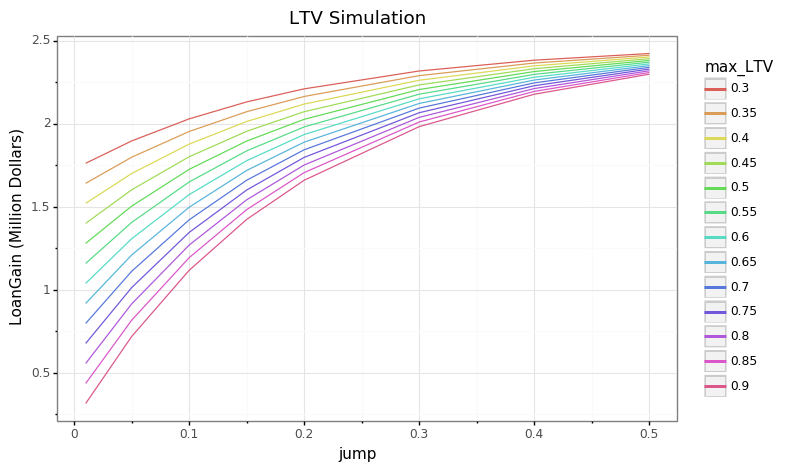

<ggplot: (323003869)>

In [244]:
import plotnine
plotnine.options.figure_size = (8, 5)

(
sim_values >>
    mutate(LoanGain = X.LoanGain/1000000) >>
    mutate(max_LTV = X.max_LTV.astype('str')) >>
    ggplot() +
    geom_line(aes(x = 'jump', y = 'LoanGain', group = 'max_LTV', colour = 'max_LTV')) +
    ggtitle('LTV Simulation') +
    theme_bw() +
    ylab('LoanGain (Million Dollars)')
)

# Simulation - Last Action: Score Threshold

This simulation will be very similar than the last one.

In the last simulation, we consider the **last action** as the real last action for each loan, in this one, we will try for different _score thresholds_ to suppose if the loan will drop or redeem:

$$
lastAction_{Loan} =
\begin{cases}
score_{Loan} >= threshold, & \text{Drop} \\
score_{Loan} < threshold, & \text{Redeem}
\end{cases}
$$

In [232]:
d = {'threshold':[],
     'max_LTV'  :[],
     'jump'     :[],
     'LoanGain' :[],
     'VaR'      :[]
}

sim_values_thr = pd.DataFrame(d)

In [233]:
thresholds=[0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,
            0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]

In [188]:
valid['Sum_OriginalPrice']=valid['total_original_price_GM']+valid['total_original_price_JW']

In [234]:
for t in thresholds:
    valid['lastAction_t']=np.where(valid.score >= t, 1, 0)
    for i in max_LTV:
        for j in jump:
            # Calculate the LTV Simulated for each quantile
            valid['LTV_Simulated']=np.where(valid['quantile']=='q10%',i,
                                            np.where(valid['quantile']=='q20%',i*(1-j),
                                                     np.where(valid['quantile']=='q30%',i*(1-j)**2,
                                                              np.where(valid['quantile']=='q40%',i*(1-j)**3,
                                                                       np.where(valid['quantile']=='q50%',i*(1-j)**4,
                                                                                np.where(valid['quantile']=='q60%',i*(1-j)**5,
                                                                                         np.where(valid['quantile']=='q70%',i*(1-j)**6,
                                                                                                  np.where(valid['quantile']=='q80%',i*(1-j)**7,
                                                                                                           np.where(valid['quantile']=='q90%',i*(1-j)**8,
                                                                                                                    np.where(valid['quantile']=='q100%',i*(1-j)**9,-1))))))))))
            # Get the total original price
            valid['Sum_OriginalPrice']=valid['total_original_price_GM']+valid['total_original_price_JW']
        
            # Calculate the Loan Simulated: OriginalPrice*LTV Simulated
            valid['Loan_Simulated'] = (valid.Sum_OriginalPrice)*valid['LTV_Simulated']
        
            # Calculate the PSC Simu lated: PSC% * Loan Simulated
            valid['PSC_Simulated'] = valid['Loan_Simulated']*valid.PSC_pct
        
            # Calculate the real LTV: Loan Amount / Original Price
            valid['LTV_Real']=valid['loanAmt_allItems']/(valid.Sum_OriginalPrice)
        
            # Create an auxiliar DataFrame with validation data at item level to get
            # the sold price expected
            valid_aux = valid.copy()
        
            # Add at item level, the original_price and the AVG_sold_pct
            valid_aux = valid_aux.merge(datas[['primaryLoan','MDMcustomerID', 'itemID',
                                               'itemLoanAmt', 'sold_price',
                                               'original_price','AVG_Sold_pct']],
                                        on  = ['primaryLoan','MDMcustomerID'],
                                        how = 'left')
        
            real_sold_gain = valid_aux.sold_price - valid_aux.itemLoanAmt
            real_sold_gain = real_sold_gain.sum()
        
            # Calculate the Expected Loan Amt at item level
            valid_aux['Loan_Simulated']=valid_aux.original_price*valid_aux.LTV_Simulated
        
            # Calculate the sold price expected at item level
            valid_aux['SoldPrice_Expected']=valid_aux.AVG_Sold_pct*valid_aux.original_price
        
            # Calculate the sold gain at item level
            valid_aux['SoldGain_item']=valid_aux['SoldPrice_Expected']-valid_aux['Loan_Simulated']
        
            # Calculate the Sold Gain by PrimaryLoan and MDMCustomerID
            valid_aux = valid_aux.groupby(['primaryLoan','MDMcustomerID'])['SoldGain_item'].agg('sum')
            valid_aux = pd.DataFrame(valid_aux).reset_index()
            valid_aux.columns=['primaryLoan','MDMcustomerID','SoldGain']
        
            # Add the SoldGain to valid data
            valid_aux2=valid.merge(valid_aux,
                                   on = ['primaryLoan','MDMcustomerID'],
                                   how = 'left')
        
            # Add the gain for Drop and Redeem
            valid_aux2['LoanGain']=np.where(valid_aux2.lastAction_t==1,
                                            valid_aux2.PSC_Simulated+valid_aux2.SoldGain,
                                            valid_aux2.PSC_Simulated)
        
            real_PSC_gain = valid_aux2.loanPSC.sum()
        
            aux={'threshold':t,
                 'max_LTV':i,
                 'jump'   :j,
                 'LoanGain':valid_aux2[valid_aux2['LTV_Real']<=1].LoanGain.sum(),
                 'VaR':(1.64)*(valid_aux2.LoanGain.sum())*(valid_aux2.LoanGain.std())*(math.sqrt(6.0))
                 }
            aux=pd.DataFrame(aux, index=[0])
            sim_values_thr=sim_values_thr.append(aux).copy()

In [235]:
sim_values_thr.sort_values(by=['LoanGain'], ascending = False)

threshold  max_LTV  jump      LoanGain           VaR
0        0.10     0.30  0.50  4.160147e+06  4.347365e+09
0        0.10     0.35  0.50  4.105243e+06  4.248958e+09
0        0.10     0.30  0.40  4.064726e+06  4.156749e+09
0        0.10     0.40  0.50  4.050339e+06  4.153571e+09
0        0.15     0.30  0.50  4.039646e+06  4.202768e+09
..        ...      ...   ...           ...           ...
0        0.95     0.30  0.50  9.441407e+04  4.865203e+06
0        0.25     0.90  0.01  9.155282e+04  3.532885e+07
0        0.20     0.90  0.01  2.918575e+04  1.068113e+07
0        0.15     0.90  0.01 -4.439623e+04 -1.766661e+07
0        0.10     0.90  0.01 -8.465234e+04 -3.272382e+07

[2106 rows x 5 columns]

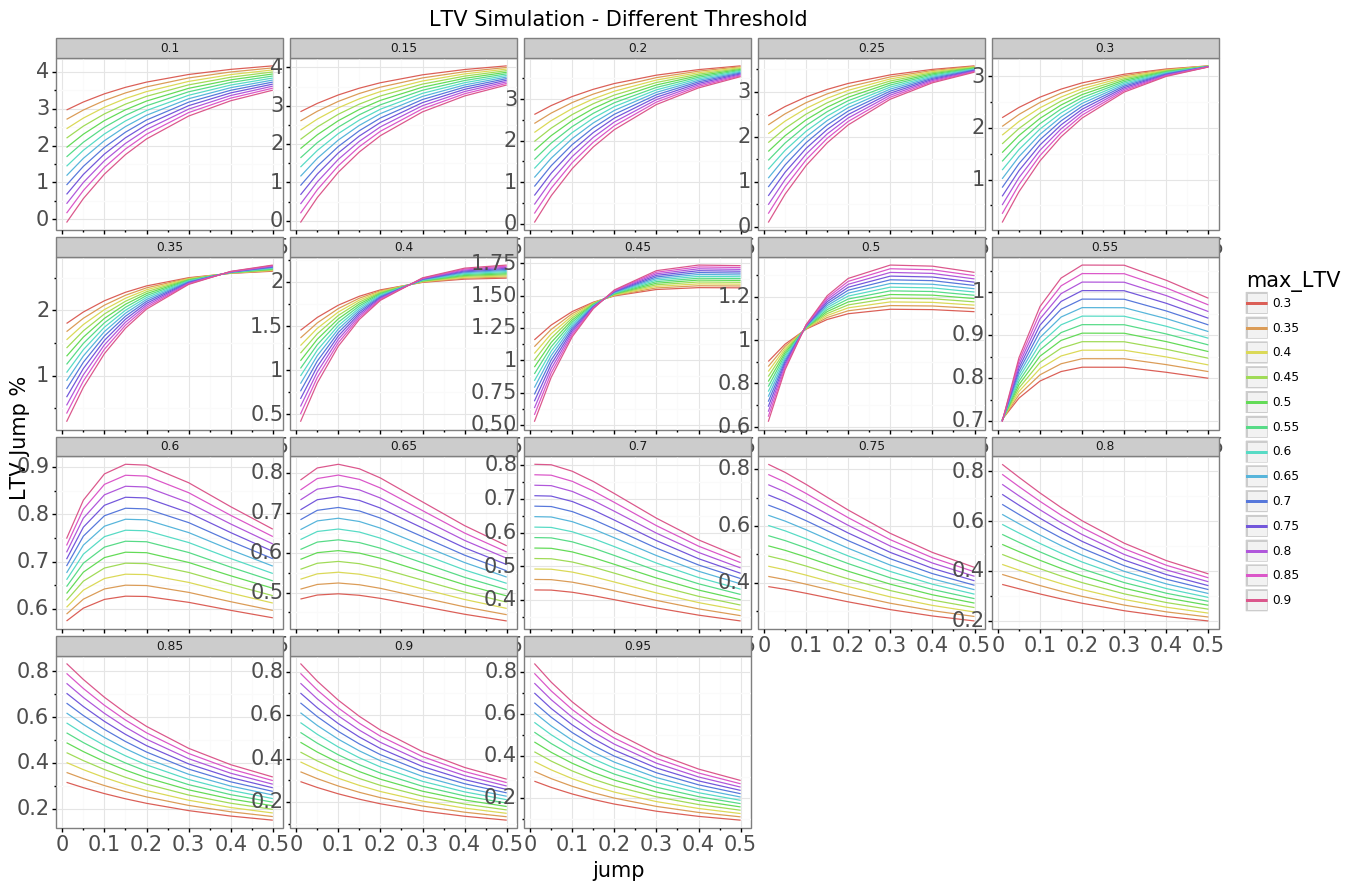

<ggplot: (331461761)>

In [247]:
plotnine.options.figure_size = (15, 10)

(
sim_values_thr >>
    mutate(LoanGain = X.LoanGain/1000000) >>
    mutate(max_LTV = X.max_LTV.astype('str')) >>
    ggplot() +
    geom_line(aes(x = 'jump', y = 'LoanGain', group = 'max_LTV', colour = 'max_LTV')) +
    theme_bw() +
    ggtitle('LTV Simulation - Different Threshold') +
    facet_wrap('~threshold', scales = 'free') +
    ylab('LoanGain (million dollars)') +
    ylab('LTV Jump %') +
    theme(axis_text_x  = element_text(size = 15),
          axis_text_y  = element_text(size = 15),
          axis_title_x = element_text(size = 15),
          axis_title_y = element_text(size = 15),
          title        = element_text(size = 15))
)

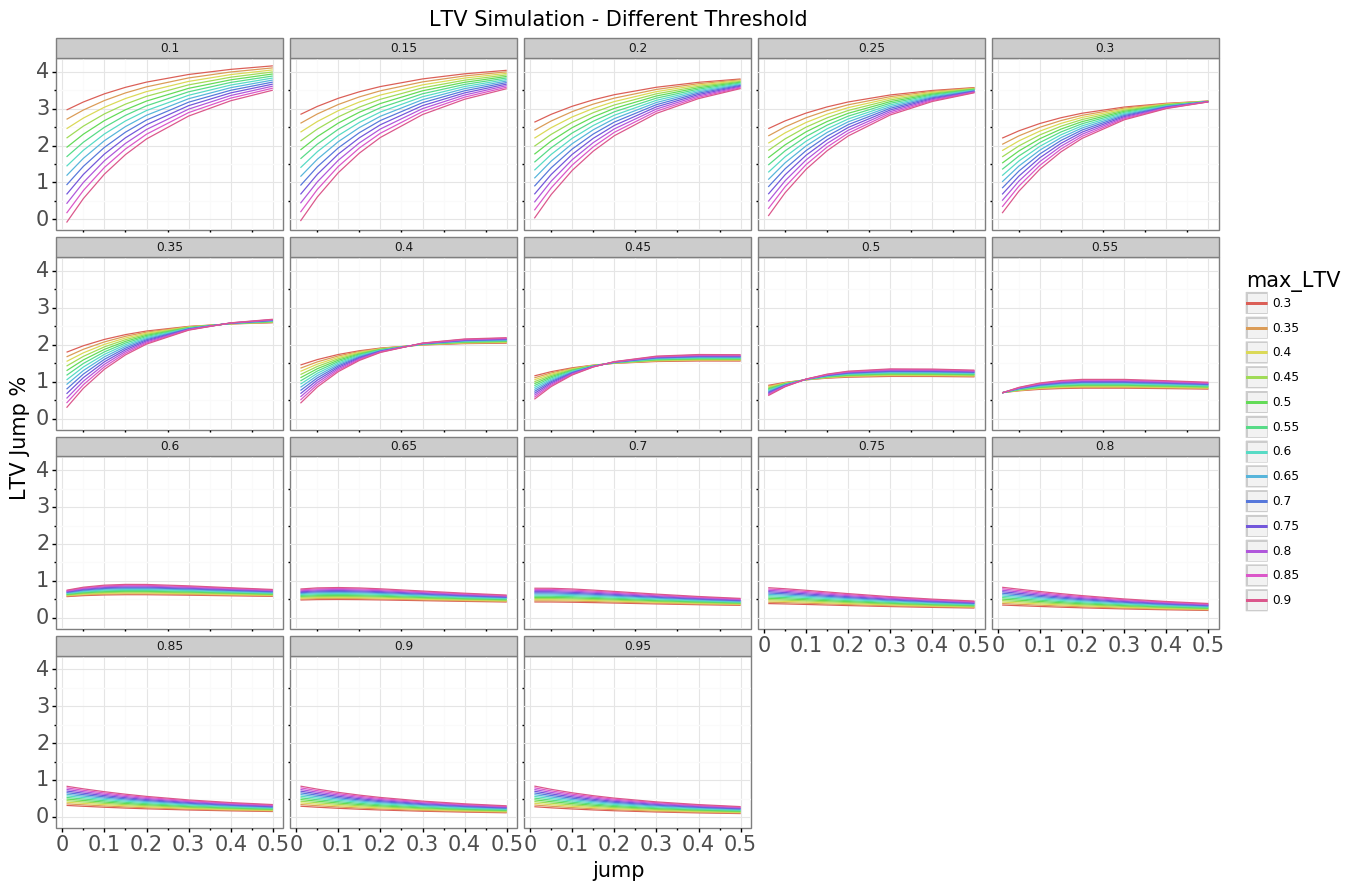

<ggplot: (318285681)>

In [248]:
plotnine.options.figure_size = (15, 10)

(
sim_values_thr >>
    mutate(LoanGain = X.LoanGain/1000000) >>
    mutate(max_LTV = X.max_LTV.astype('str')) >>
    ggplot() +
    geom_line(aes(x = 'jump', y = 'LoanGain', group = 'max_LTV', colour = 'max_LTV')) +
    theme_bw() +
    ggtitle('LTV Simulation - Different Threshold') +
    facet_wrap('~threshold') +
    ylab('LoanGain (million dollars)') +
    ylab('LTV Jump %') +
    theme(axis_text_x  = element_text(size = 15),
          axis_text_y  = element_text(size = 15),
          axis_title_x = element_text(size = 15),
          axis_title_y = element_text(size = 15),
          title        = element_text(size = 15))
)

# Threshold Confusion Matrix - Simulation

In this excercise we are going to make a simulation using again a _score threshold_, but comparing it with the real _Last Action_, so in simple words, we are going to have a _confusion matrix_ for each loan.

It will be asigned 2 simulated LTVs:
 - Drop LTV
 - Redeem LTV

And we will see what happend with different score thresholds, using the Drop and Redeem LTVs simulated.

$$
lastAction_{Loan} =
\begin{cases}
score_{Loan} >= threshold, & \text{Drop} \\
score_{Loan} < threshold, & \text{Redeem}
\end{cases}
$$

So, if we know the:
 - Predicted Last Action with the _score_ threshold
 - Simulated LTVs for Drop and Redeem
 - PSC & SGP adjusted for the LTV simulated
 
Then, for each of the 4 possible scenarios in the _confusion matrix_, we can calculate a **Gain/Loss**:

|   Scenario     |         Description           |      Formula      |
|:--------------:|:-----------------------------:|:-----------------:|
| True Positive  | Predict Drop, Actual Drop     | (ALG LoanAmt - CG Loan Amt) - (ALG PSC - CG PSC) |
| False Positive | Predict Drop, Actual Redeem   | CG PSC - ALG PSC  |
| True Negative  | Predict Redeem, Actual Redeem | CG PSC - ALG PSC  |
| False Negative | Predict Redeem, Actual Drop   | (ALG LoanAmt - CG LoanAmt) + (CG PSC - ALG PSC) |

Formulas:

$\text{ALG LoanAmt}_{Loan} = \text{Current Loan Amt}_{Loan}$

$\text{ALG PSC}_{Loan} = \text{Current PSC}_{Loan}$

$\text{CG Loan Amt}_{Loan} = \text{Original Price}_{Loan}*\text{LTV Simulated}$

$\text{PSC Yield}_{Loan} = \frac{\text{ALG PSC}_{Loan}}{\text{ALG LoanAmt}_{Loan}}$

$\text{CG PSC}_{Loan} = \text{PSC Yield}_{Loan}*\text{CG LoanAmt}_{Loan}$

Then, with the **Gain/Loss** for each _scenario_, it will be calculated a **Total Gain**, that is the sum of the **Gain/Loss** of all scenarios.

The **Simulated Drop/Redeem LTVs** will be complementary:
 - Drop LTV = X
 - Redeem LTV = 1 - X

Define _score_ thresholds

In [334]:
quans = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
thresholds=valid.score.quantile(quans).tolist()
#thresholds=[0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,
#            0.55,0.60, 0.62]

Define Drop LTVs

In [312]:
drop_ltvs = [0.25,0.30,0.35,0.40,0.45,0.50,0.55,
             0.60,0.65,0.70,0.75,0.80,0.85,0.90]

Create **PSC YIELD**

In [185]:
valid['PSC_Yield']=valid.loanPSC/valid.loanAmt_allItems
valid['PSC_Yield']=valid['PSC_Yield'].fillna(0)

Data Frame to insert the for results

In [342]:
d = {'score_threshold':[],
     'score_quantile' :[],
     'drop_ltv'       :[],
     'redeem_ltv'     :[],
     'TP_GL'          :[],
     'FP_GL'          :[],
     'TN_GL'          :[],
     'FN_GL'          :[],
     'Total_GainLoss' :[]
}

sim_values_CM = pd.DataFrame(d)

Create _for loop_

In [343]:
q=0
# Threshold loop
for i in thresholds:
    # LTV Loop
    for j in drop_ltvs:
        # Define LTVs and threshold
        drop_ltv   = j
        redeem_ltv = 1-j
        score_thre = i
        
        # Define Last Action simulated with score threshold
        valid['lastAction_sim'] = np.where(valid.score >= score_thre, 1, 0)
        
        # Create Gain/Loss features
        valid['ALG_LA'] = valid.loanAmt_allItems
        valid['ALG_PSC'] = valid.loanPSC
        valid['CG_LA']   = np.where(valid.lastAction_sim==1,
                                    valid.Sum_OriginalPrice*drop_ltv,
                                    valid.Sum_OriginalPrice*redeem_ltv)
        valid['CG_PSC']  = valid.PSC_Yield*valid.CG_LA
        
        # Create matriz confusion dummies
        valid['TP']             = np.where((valid.lastAction_sim==1) & (valid.lastAction==1),
                                           1, 0)
        valid['FP']             = np.where((valid.lastAction_sim==1) & (valid.lastAction==0),
                                           1,0)
        valid['TN']             = np.where((valid.lastAction_sim==0) & (valid.lastAction==0),
                                           1,0)
        valid['FN']             = np.where((valid.lastAction_sim==0) & (valid.lastAction==1),
                                           1,0)
        
        # Calculate Gain/Loss for the confusion matrix scenarios
        valid['TP_GL'] = (valid.ALG_LA - valid.CG_LA) - (valid.ALG_PSC - valid.CG_PSC)
        valid['TP_GL'] = valid.TP_GL*valid.TP
        
        valid['FP_GL'] = valid.CG_PSC - valid.ALG_PSC
        valid['FP_GL'] = valid.FP_GL*valid.FP
        
        valid['TN_GL'] = valid.CG_PSC - valid.ALG_PSC
        valid['TN_GL'] = valid.TN_GL*valid.TN
        
        valid['FN_GL'] = (valid.ALG_LA - valid.CG_LA) + (valid.CG_PSC - valid.ALG_PSC)
        valid['FN_GL'] = valid.FN_GL*valid.FN
        
        # Insert values into for loop data
        a = {'score_threshold':score_thre,
             'score_quantile' :quans[q],
             'drop_ltv'       :drop_ltv,
             'redeem_ltv'     :redeem_ltv,
             'TP_GL'          :valid.TP_GL.sum(),
             'FP_GL'          :valid.FP_GL.sum(),
             'TN_GL'          :valid.TN_GL.sum(),
             'FN_GL'          :valid.FN_GL.sum(),
             'Total_GainLoss' :valid.TP_GL.sum()+valid.FP_GL.sum()+valid.TN_GL.sum()+valid.FN_GL.sum()
            }
        a=pd.DataFrame(a, index=[0])
        sim_values_CM=sim_values_CM.append(a).copy()
    q=q+1

In [344]:
valid[['lastAction','lastAction_sim','TP','FP','TN','FN',
       'ALG_LA','ALG_PSC','CG_LA','CG_PSC',
       'TP_GL','FP_GL','TN_GL','FN_GL']]

lastAction  lastAction_sim  TP  FP  TN  FN  ALG_LA  ALG_PSC  \
0               0               0   0   0   1   0      25     6.25   
1               0               0   0   0   1   0      70    16.80   
2               1               0   0   0   0   1     205     0.00   
3               0               0   0   0   1   0     110    27.50   
4               1               1   1   0   0   0     300     0.00   
...           ...             ...  ..  ..  ..  ..     ...      ...   
26038           1               0   0   0   0   1      45     0.00   
26039           0               0   0   0   1   0     150   121.00   
26040           1               1   1   0   0   0      17     0.00   
26041           1               0   0   0   0   1      50     0.00   
26042           0               0   0   0   1   0     125    15.00   

            CG_LA     CG_PSC       TP_GL  FP_GL      TN_GL       FN_GL  
0        6.999000   1.749750    0.000000   -0.0  -4.500250    0.000000  
1       17.998000   4.319520    0.000000   -0.0 -12.480480    0.000000  
2       51.498999   0.000000    0.000000    0.0   0.000000  153.501001  
3       21.999001   5.499750    0.000000   -0.0 -22.000250    0.000000  
4      611.990991   0.000000 -311.990991    0.0   0.000000   -0.000000  
...           ...        ...         ...    ...        ...         ...  
26038   11.099000   0.000000    0.000000    0.0   0.000000   33.901000  
26039   36.498999  29.442526    0.000000   -0.0 -91.557474    0.000000  
26040   58.472999   0.000000  -41.472999    0.0   0.000000   -0.000000  
26041   12.599000   0.000000    0.000000    0.0   0.000000   37.401000  
26042   31.998999   3.839880    0.000000   -0.0 -11.160120    0.000000  

[26043 rows x 14 columns]

In [345]:
sim_values_CM.sort_values(by=['Total_GainLoss'], ascending = False)

score_threshold  score_quantile  drop_ltv  redeem_ltv         TP_GL  \
0          0.607228            0.80      0.90        0.10 -2.730862e+05   
0          0.274510            0.20      0.25        0.75  4.902771e+05   
0          0.607228            0.80      0.85        0.15 -2.455580e+05   
0          0.309107            0.25      0.25        0.75  4.502244e+05   
0          0.574046            0.75      0.90        0.10 -3.476655e+05   
..              ...             ...       ...         ...           ...   
0          0.274510            0.20      0.80        0.20 -1.159368e+06   
0          0.309107            0.25      0.85        0.15 -1.214380e+06   
0          0.274510            0.20      0.85        0.15 -1.309335e+06   
0          0.309107            0.25      0.90        0.10 -1.353097e+06   
0          0.274510            0.20      0.90        0.10 -1.459303e+06   

            FP_GL          TN_GL          FN_GL  Total_GainLoss  
0    19906.732650 -314011.607993  922036.659590    3.548456e+05  
0  -109769.060315   90942.838203 -120622.293065    3.508286e+05  
0    17873.247503 -268011.091990  778839.939384    2.831441e+05  
0   -94200.921965  117608.923154 -193076.496609    2.805559e+05  
0    27941.810717 -309177.585556  879181.260058    2.502800e+05  
..            ...            ...            ...             ...  
0   238521.298991  -89140.815146  107706.894516   -9.022804e+05  
0   235071.129318 -129527.039369  191018.228678   -9.178176e+05  
0   270184.058928 -105512.056359  128464.093387   -1.016199e+06  
0   262510.466925 -150121.702913  223026.122452   -1.017682e+06  
0   301846.818865 -121883.297573  149221.292258   -1.130118e+06  

[182 rows x 9 columns]

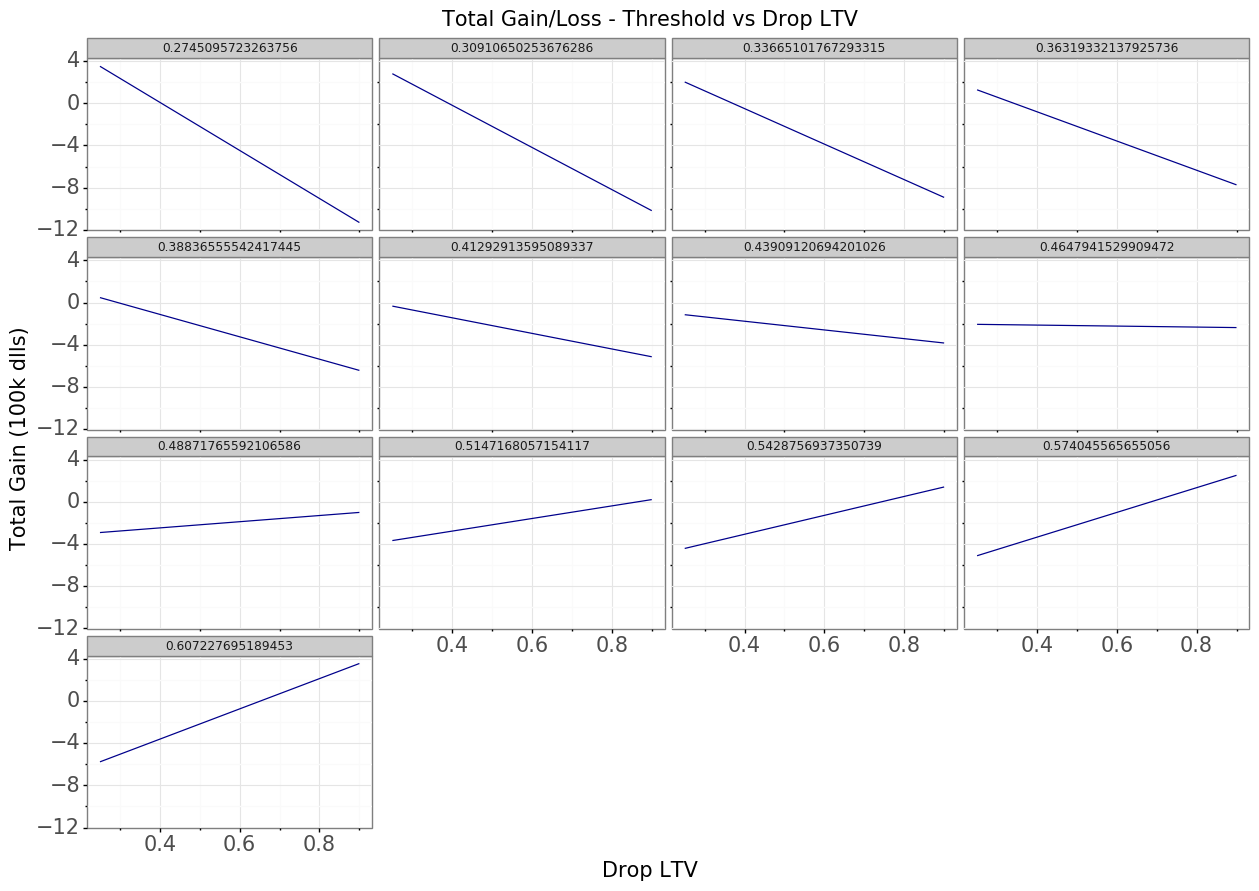

<ggplot: (331706437)>

In [346]:
(
sim_values_CM >>
    mutate(Total_GainLoss = X.Total_GainLoss/100000) >>
    ggplot() +
    geom_line(aes(x = 'drop_ltv', y = 'Total_GainLoss'), colour = 'darkblue') +
    ggtitle('Total Gain/Loss - Threshold vs Drop LTV') +
    theme_bw() +
    facet_wrap('~score_threshold') +
    ylab('Total Gain (100k dlls)') +
    xlab('Drop LTV') +
    theme(axis_text_x  = element_text(size = 15),
          axis_text_y  = element_text(size = 15),
          axis_title_x = element_text(size = 15),
          axis_title_y = element_text(size = 15),
          title        = element_text(size = 15))
)

# Optimize LTV by Predictive Model

We will predict % of gain per loan, in function of the score quantile and the real LTV.

This to analyze which is the optimal LTV that Maximize the % of gain.

$\text{% Gain}_{Loan} = \frac{\text{PSC}_{Loan}+\text{Sale Gain}_{Loan}}{\text{Loan Amount}_{Loan}}$

$\text{% Gain}_{Loan} = \sum_{n=1}^{10} \theta_n*\text{Decile Dummy}_{n_{Loan}} + \beta_1*\text{LTV}_{Loan}$

Put the decile label in the validation set

In [186]:
valid['decile'] = pd.qcut(valid.score, q=[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,
                                          0.7,0.8,0.9,1.0], 
                                   labels=['q10%','q20%','q30%','q40%','q50%',
                                           'q60%','q70%','q80%','q90%','q100%'])

In [189]:
valid['LTV'] = valid.loanAmt_allItems/valid.Sum_OriginalPrice


In [190]:
valid['pct_gain'] = np.where(valid.lastAction == 1,
                             valid.loanPSC + (valid.Sum_OriginalPrice-valid.loanAmt_allItems),
                             valid.loanPSC)
valid['pct_gain'] = valid.pct_gain/valid.loanAmt_allItems


Create a new Data Frame to create the model

In [446]:
data_v = valid[['decile','LTV','pct_gain']]


Drop outliers of pct gain

In [447]:
data_v=data_v[data_v.pct_gain>=data_v.pct_gain.quantile(.05)]
data_v=data_v[data_v.pct_gain<=data_v.pct_gain.quantile(.95)]

Drop LTV outliers

In [448]:
data_v=data_v[data_v.LTV<=1]
data_v=data_v[data_v.LTV>=0]

Get Dummies of deciles

In [449]:
X_data_v = pd.get_dummies(data_v[['decile','LTV']],columns=['decile'])


In [450]:
y_data_v = data_v.pct_gain


Split

In [451]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_data_v,
                                                            y_data_v,
                                                            test_size=0.4,
                                                            random_state=10)

In [452]:
DX_train = lgb.Dataset(data = X_train_v, label = y_train_v.values)


Metaparameter Optimation

In [453]:
fit_params={"early_stopping_rounds": 10, 
            "eval_metric"          : 'rmse', 
            "eval_set"             : [(X_test_v,y_test_v)],
            'eval_names'           : ['valid'],
            'verbose'              : 100}

In [454]:
param_test ={'num_leaves'       : sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample'        : sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree' : sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha'        : [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda'       : [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [455]:
n_HP_points_to_test = 200

In [456]:
clf = lgb.LGBMRegressor(max_depth     = -1,
                        random_state = 314,
                        silent       = True,
                        metric       = 'rmse',
                        n_jobs       = 4,
                        n_estimators = 500)

In [457]:
gs = RandomizedSearchCV(estimator           = clf,
                        param_distributions = param_test, 
                        n_iter              = n_HP_points_to_test,
                        scoring             = 'explained_variance',
                        cv                  = 3,
                        random_state        = 314)

In [458]:
cv_fit_v = gs.fit(X_train_v, y_train_v.values)

In [459]:
print('Best score reached: {} with params: {} '.format(cv_fit_v.best_score_, cv_fit_v.best_params_))

Best score reached: 0.2987716162619712 with params: {'colsample_bytree': 0.5127511987625902, 'min_child_samples': 111, 'min_child_weight': 1, 'num_leaves': 17, 'reg_alpha': 5, 'reg_lambda': 10, 'subsample': 0.6148858291987234} 


In [460]:
opt_parameters = cv_fit_v.best_params_

Het the best model

In [461]:
#Configure locally from hardcoded values
clf_final_v = lgb.LGBMRegressor(max_depth     = -1,
                             random_state = 314,
                             silent       = True,
                             metric       = 'rmse',
                             n_jobs       = 12,
                             n_estimators = 1000)

In [462]:
#set optimal parameters
clf_final_v.set_params(**opt_parameters)

LGBMRegressor(colsample_bytree=0.5127511987625902, metric='rmse',
              min_child_samples=111, min_child_weight=1, n_estimators=1000,
              n_jobs=12, num_leaves=17, random_state=314, reg_alpha=5,
              reg_lambda=10, subsample=0.6148858291987234)

In [463]:
#Train the final model with learning rate decay
clf_final_v.fit(X_train_v,
                y_train_v,
                **fit_params,
                callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid's rmse: 0.571472


LGBMRegressor(colsample_bytree=0.5127511987625902, metric='rmse',
              min_child_samples=111, min_child_weight=1, n_estimators=1000,
              n_jobs=12, num_leaves=17, random_state=314, reg_alpha=5,
              reg_lambda=10, subsample=0.6148858291987234)

In [464]:
data_v['pct_gain_pred']=clf_final_v.predict(X_data_v)


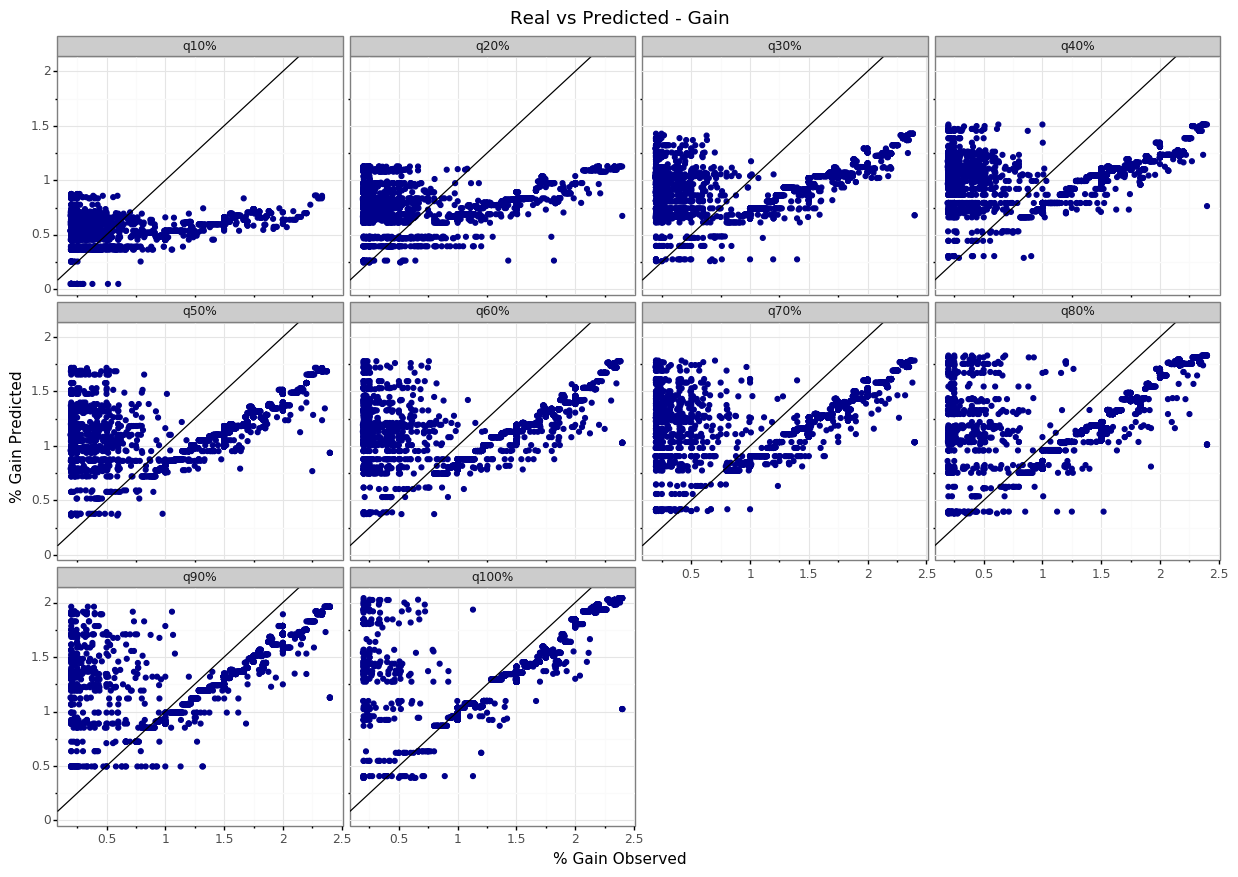

<ggplot: (359388117)>

In [465]:
plotnine.options.figure_size = (15, 10)
(
data_v >>
    ggplot() +
    geom_point(aes(x = 'pct_gain', y = 'pct_gain_pred'), colour = 'darkblue') +
    geom_abline(slope = 1, intercept = 0) +
    facet_wrap('~decile') +
    theme_bw() +
    ggtitle('Real vs Predicted - Gain')  +
    ylab('% Gain Predicted') +
    xlab('% Gain Observed')
)

Marginal Effects for LTV

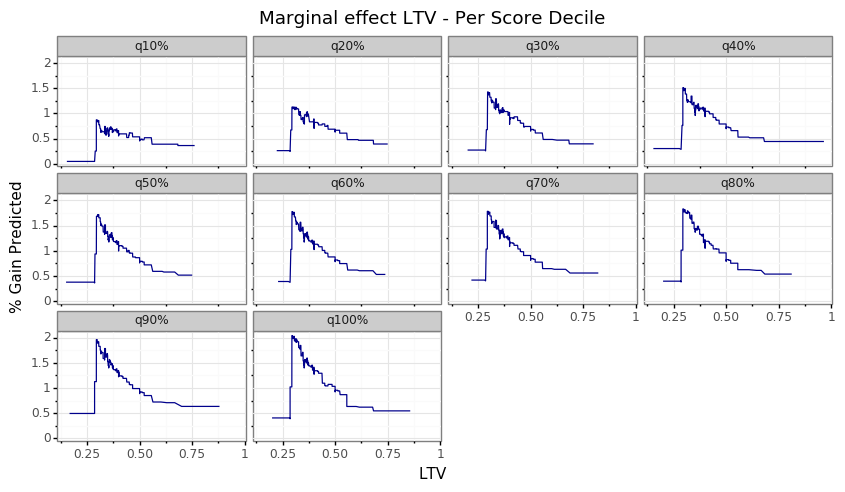

<ggplot: (335546741)>

In [470]:
plotnine.options.figure_size = (10, 5)
(
data_v >>
    mask(X.LTV <= 1, X.LTV >= 0) >>
    distinct(X.decile,X.LTV,X.pct_gain_pred) >>
    ggplot() +
    geom_line(aes(x = 'LTV', y = 'pct_gain_pred'), colour = 'darkblue') +
    theme_bw() +
    ggtitle('Marginal effect LTV - Per Score Decile') +
    facet_wrap('~decile') +
    ylab('% Gain Predicted') +
    xlab('LTV')
)

Average LTV per quantile

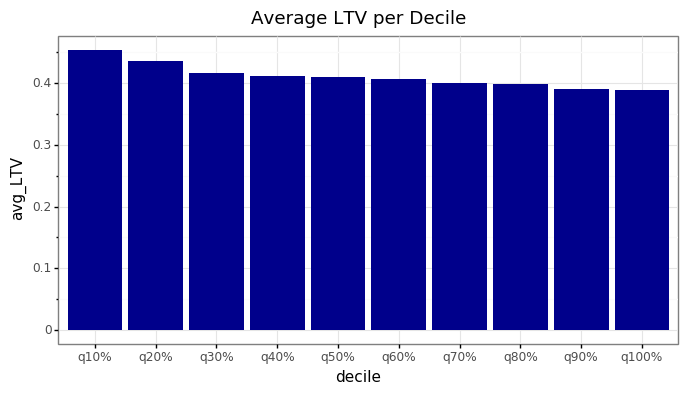

<ggplot: (325514577)>

In [471]:
plotnine.options.figure_size = (8, 4)
(
data_v >>
    group_by(X.decile) >>
    summarise(avg_LTV = X.LTV.mean()) >>
    ggplot() +
    geom_col(aes(x = 'decile', y = 'avg_LTV'), fill = 'darkblue') +
    ggtitle('Average LTV per Decile') +
    theme_bw()
)

In [192]:
valid.to_csv("/Users/darias/Downloads/Valid_Data.csv") 